In [15]:
#insall libraries

#!pip install lightgbm

  Using cached lightgbm-3.1.1-py2.py3-none-macosx_10_13_x86_64.macosx_10_14_x86_64.macosx_10_15_x86_64.whl (1.0 MB)
     |████████████████████████████████| 30.9 MB 5.2 MB/s eta 0:00:01
     |████████████████████████████████| 7.3 MB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 3.5 MB/s eta 0:00:01


In [5]:
#import the necessay modules
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import cm
import re
from scipy import stats
import warnings
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#import lightgbm as lgb
import eli5
from eli5.sklearn import PermutationImportance
#from lightgbm import LGBMClassifier
# from matplotlib import pyplot as plt
# from pdpbox import pdp, get_dataset, info_plots

import io
import os
import sys
import requests
from io import StringIO
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

### Code to import the data from a table from wikipedia 
import requests
website_url = requests.get("https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods").text
from bs4 import BeautifulSoup
soup = BeautifulSoup(website_url, 'html.parser')
tables = soup.find_all('table')
Neighbourhood = []
Area = []
#### tables[1].find_all('tr')[0].find_all('td')[1].text
#### tables[2].find_all('tr')[1].find_all('td')[4].text.strip()

for table in [1,2,5]:
    rows = tables[table].find_all('tr')
    for row in rows:
        cells = row.find_all('td')
        if len(cells) > 1:
            neighbourhood = cells[0]
            Neighbourhood.append(neighbourhood.text.strip())
            area = cells[4]
            Area.append(area.text.strip())
Area = [float(a) for a in Area if len(a)>1]
Neighbourhood = [n for n in Neighbourhood if len(n)>1]

In [6]:
# load TPS data 2014-2019

url = "https://opendata.arcgis.com/datasets/56a0d46ae5f141269f2598a8c07e25c1_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D"
t=requests.get(url).content
df_crime=pd.read_csv(io.StringIO(t.decode('utf-8')))

In [7]:
# load Toronto Open Data

url = urlopen('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/fa139bae-8e6b-4e0c-8b36-53161970f89e')
myzip = ZipFile(BytesIO(url.read())).extract('Registered_Programs_and_Drop_In_Courses_Offering.xlsx')
df_programs = pd.read_excel(myzip, sheet_name=0)
df_dropin = pd.read_excel(myzip,sheet_name=1)
df_locations = pd.read_excel(myzip, sheet_name=2)
df_facilities = pd.read_excel(myzip,sheet_name=3)

In [8]:
# load neighbourd crime rates from TPS - includes population of each neighbourhood

url = "https://opendata.arcgis.com/datasets/af500b5abb7240399853b35a2362d0c0_0.csv?outSR=%7B%22latestWkid%22%3A26717%2C%22wkid%22%3A26717%7D"
t=requests.get(url).text
t=requests.get(url).content
df_pop=pd.read_csv(io.StringIO(t.decode('utf-8')))


In [9]:
#import the data
#address = r'C:\Users\sharm.LAPTOP-118C54MT\OneDrive - York University\Big Data Analytics course\Project'
dropc_crime = ["X", "Y", "Index_", "ucr_code", "ucr_ext", "Division", "ObjectId"]
keepc_pop = ["Hood_ID", "Population"]
keepc_crc = ["Hood_ID", "Location Name", "Ward"]
#df_crime = pd.read_csv(address + r'\MCI_2014_to_2019.csv')
df_crc = pd.read_csv(os.path.join(sys.path[0], 'Mapping of CRC to TPS.csv'), usecols=keepc_crc)
#df_pop = pd.read_csv(address + r'\Neighbourhood_Crime_Rates.csv', usecols=keepc_pop)
#df_PopDen = pd.read_csv(address + r'\PopdenNeig.csv')
df_PopDen = pd.read_csv(os.path.join(sys.path[0], 'PopdenNeig.csv'))
df_PopDen = df_PopDen.iloc[[0,7],6::].T
df_PopDen.columns = ['Hood_ID', 'PopDen']
df_PopDen['Hood_ID'] = df_PopDen['Hood_ID'].apply(lambda x: int(x))
df_PopDen['PopDen'] = df_PopDen['PopDen'].apply(lambda x: float(x.replace(',','')))
df_crime.drop(dropc_crime, axis=1, inplace=True)
df_crime = pd.merge(df_crime, df_pop, how='left', left_on='Hood_ID', right_on='Hood_ID')
df_crime = df_crime.merge(df_PopDen, how='left', on='Hood_ID')
df_crime = df_crime[df_crime.occurrenceyear>2013]
df_crime.occurrencedate = pd.to_datetime(df_crime.occurrencedate)
df_crime.reporteddate = pd.to_datetime(df_crime.reporteddate)
df_pop.shape
df_crc.head()
df_crime.head()

event_unique_id            occurrencedate              reporteddate  \
0  GO-20141301077 2014-01-07 05:00:00+00:00 2014-01-07 05:00:00+00:00   
1  GO-20141301077 2014-01-07 05:00:00+00:00 2014-01-07 05:00:00+00:00   
2  GO-20141301077 2014-01-07 05:00:00+00:00 2014-01-07 05:00:00+00:00   
3  GO-20141301077 2014-01-07 05:00:00+00:00 2014-01-07 05:00:00+00:00   
4  GO-20141300854 2014-01-07 05:00:00+00:00 2014-01-07 05:00:00+00:00   

  premisetype              offence  reportedyear reportedmonth  reportedday  \
0       Other  Assault With Weapon          2014       January            7   
1       Other  Assault With Weapon          2014       January            7   
2       Other  Assault With Weapon          2014       January            7   
3       Other  Assault With Weapon          2014       January            7   
4  Commercial                  B&E          2014       January            7   

   reporteddayofyear reporteddayofweek  ...  TheftOver_2016  TheftOver_2017  \
0                  7        Tuesday     ...               7              17   
1                  7        Tuesday     ...               7              17   
2                  7        Tuesday     ...               7              17   
3                  7        Tuesday     ...               7              17   
4                  7        Tuesday     ...               6               5   

  TheftOver_2018  TheftOver_2019  TheftOver_AVG TheftOver_CHG  \
0             10              12           10.3          0.20   
1             10              12           10.3          0.20   
2             10              12           10.3          0.20   
3             10              12           10.3          0.20   
4             17               6            8.2         -0.65   

   TheftOver_Rate_2019   Shape__Area  Shape__Length  PopDen  
0                 50.4  4.695676e+06    8634.194801  5070.0  
1                 50.4  4.695676e+06    8634.194801  5070.0  
2                 50.4  4.695676e+06    8634.194801  5070.0  
3                 50.4  4.695676e+06    8634.194801  5070.0  
4                 78.9  1.405236e+06    4971.780128  5395.0  

[5 rows x 82 columns]

In [10]:
#understand the data
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205321 entries, 0 to 206434
Data columns (total 82 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   event_unique_id          205321 non-null  object             
 1   occurrencedate           205321 non-null  datetime64[ns, UTC]
 2   reporteddate             205321 non-null  datetime64[ns, UTC]
 3   premisetype              205321 non-null  object             
 4   offence                  205321 non-null  object             
 5   reportedyear             205321 non-null  int64              
 6   reportedmonth            205321 non-null  object             
 7   reportedday              205321 non-null  int64              
 8   reporteddayofyear        205321 non-null  int64              
 9   reporteddayofweek        205321 non-null  object             
 10  reportedhour             205321 non-null  int64              
 11  occurrenceyea

In [11]:
df_crime = df_crime.drop('Neighbourhood_y',axis=1)
df_crime = df_crime.rename(columns={'Neighbourhood_x':'Neighbourhood'})

In [12]:
#describe the data
df_crime.describe()

reportedyear    reportedday  reporteddayofyear   reportedhour  \
count  205321.000000  205321.000000      205321.000000  205321.000000   
mean     2016.626833      15.748711         187.394451      12.832345   
std         1.714717       8.769403         103.537580       6.590369   
min      2014.000000       1.000000           1.000000       0.000000   
25%      2015.000000       8.000000         100.000000       8.000000   
50%      2017.000000      16.000000         189.000000      14.000000   
75%      2018.000000      23.000000         277.000000      18.000000   
max      2019.000000      31.000000         366.000000      23.000000   

       occurrenceyear  occurrenceday  occurrencedayofyear  occurrencehour  \
count   205321.000000  205321.000000        205321.000000   205321.000000   
mean      2016.607035      15.546023           186.552579       12.576775   
std          1.712493       8.882357           103.724321        7.208911   
min       2014.000000       1.000000             1.000000        0.000000   
25%       2015.000000       8.000000            99.000000        7.000000   
50%       2017.000000      16.000000           188.000000       14.000000   
75%       2018.000000      23.000000           276.000000       19.000000   
max       2019.000000      31.000000           366.000000       23.000000   

             Hood_ID            Lat  ...  TheftOver_2016  TheftOver_2017  \
count  205321.000000  205321.000000  ...   205321.000000   205321.000000   
mean       72.210086      43.707322  ...       13.789554       15.204567   
std        40.749973       0.052708  ...       14.772250       15.409014   
min         1.000000      43.587093  ...        0.000000        0.000000   
25%        36.000000      43.661152  ...        4.000000        4.000000   
50%        76.000000      43.701092  ...        8.000000        9.000000   
75%       108.000000      43.752068  ...       17.000000       22.000000   
max       140.000000      43.850788  ...       59.000000       58.000000   

       TheftOver_2018  TheftOver_2019  TheftOver_AVG  TheftOver_CHG  \
count   205321.000000   205321.000000  205321.000000  205321.000000   
mean        16.636209       18.011090      14.990411       0.246839   
std         17.314129       20.151369      15.574904       0.793901   
min          0.000000        0.000000       1.200000      -1.000000   
25%          4.000000        5.000000       4.700000      -0.250000   
50%         10.000000        9.000000       8.200000       0.080000   
75%         20.000000       22.000000      17.300000       0.380000   
max         59.000000       73.000000      56.200000       4.000000   

       TheftOver_Rate_2019   Shape__Area  Shape__Length         PopDen  
count        205321.000000  2.053210e+05  205321.000000  205321.000000  
mean             67.454125  6.234889e+06   11854.759589    7069.787163  
std              62.651616  6.465302e+06    6940.944742    5802.733736  
min               0.000000  4.241968e+05    2574.408515    1040.000000  
25%              26.900000  1.878562e+06    6933.183249    3565.000000  
50%              43.300000  4.276048e+06   10202.394229    5395.000000  
75%              84.200000  7.464327e+06   14569.478566    8943.000000  
max             283.000000  3.753449e+07   43080.724701   44321.000000  

[8 rows x 70 columns]

In [13]:
#check for the null values
df_crime.shape


(205321, 81)

In [14]:
#groupby crime category
crime_category = df_crime[['MCI','event_unique_id']].groupby('MCI').count().reset_index()


In [15]:
crime_category.columns = ['category', 'Number of crimes']

In [16]:
crime_category

category  Number of crimes
0          Assault            110609
1       Auto Theft             23330
2  Break and Enter             43214
3          Robbery             21500
4       Theft Over              6668

<IPython.core.display.Javascript object>


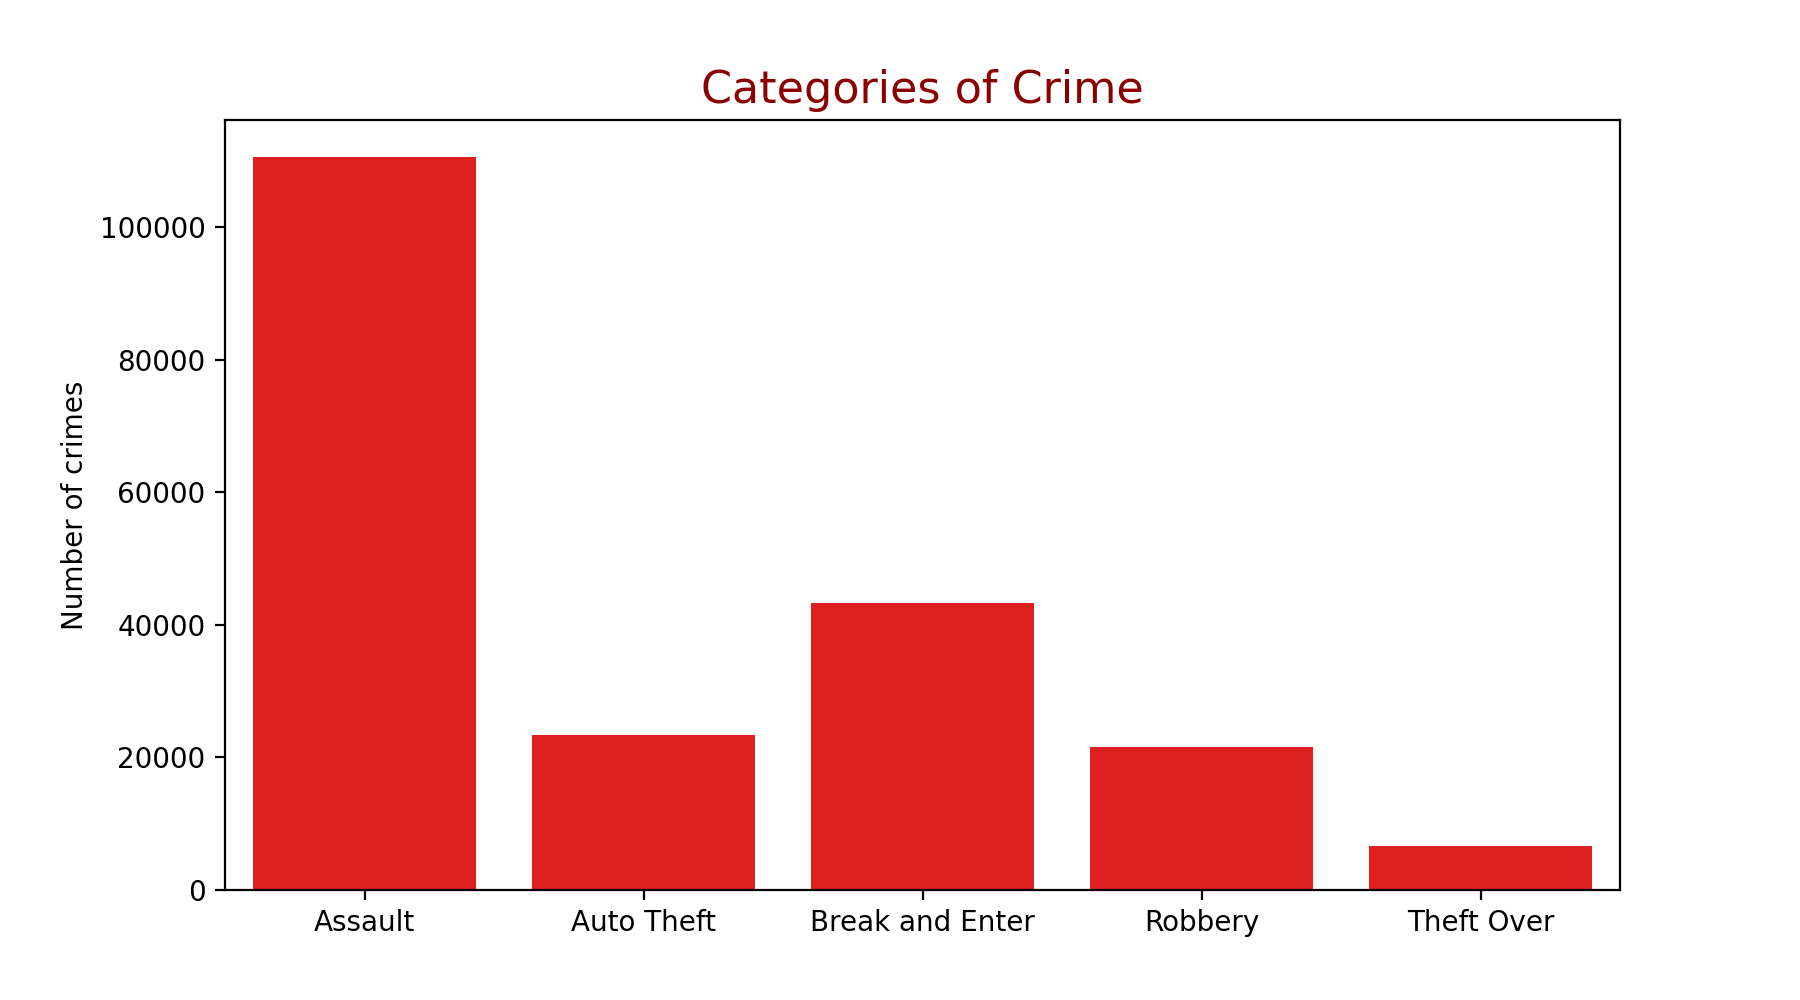

In [17]:
#plot the data 
plt.figure(figsize = (9,5))
sns.barplot(x = crime_category['category'], y = 'Number of crimes', data = crime_category, color = 'red')
plt.xticks(rotation = 0)
plt.xlabel("")
plt.title('Categories of Crime', fontdict = {'color': 'darkred', 'size':16})
#plt.text(x = 20, y = 35000,s = "Larceny/Theft : 26% \nNon-Criminal  : 11%", fontsize = 16, color = 'blue')
plt.show()

In [18]:
#groupby the data with the day of the week
crime_day = df_crime[['occurrencedayofweek','event_unique_id']].groupby('occurrencedayofweek').count().reset_index()
crime_day

occurrencedayofweek  event_unique_id
0          Friday                31231
1          Monday                28652
2          Saturday              30621
3          Sunday                29552
4          Thursday              28767
5          Tuesday               27952
6          Wednesday             28546

In [19]:
crime_day['percentage'] = (crime_day['event_unique_id']/crime_day['event_unique_id'].sum())*100
crime_day

occurrencedayofweek  event_unique_id  percentage
0          Friday                31231   15.210816
1          Monday                28652   13.954734
2          Saturday              30621   14.913720
3          Sunday                29552   14.393072
4          Thursday              28767   14.010744
5          Tuesday               27952   13.613805
6          Wednesday             28546   13.903108

<IPython.core.display.Javascript object>


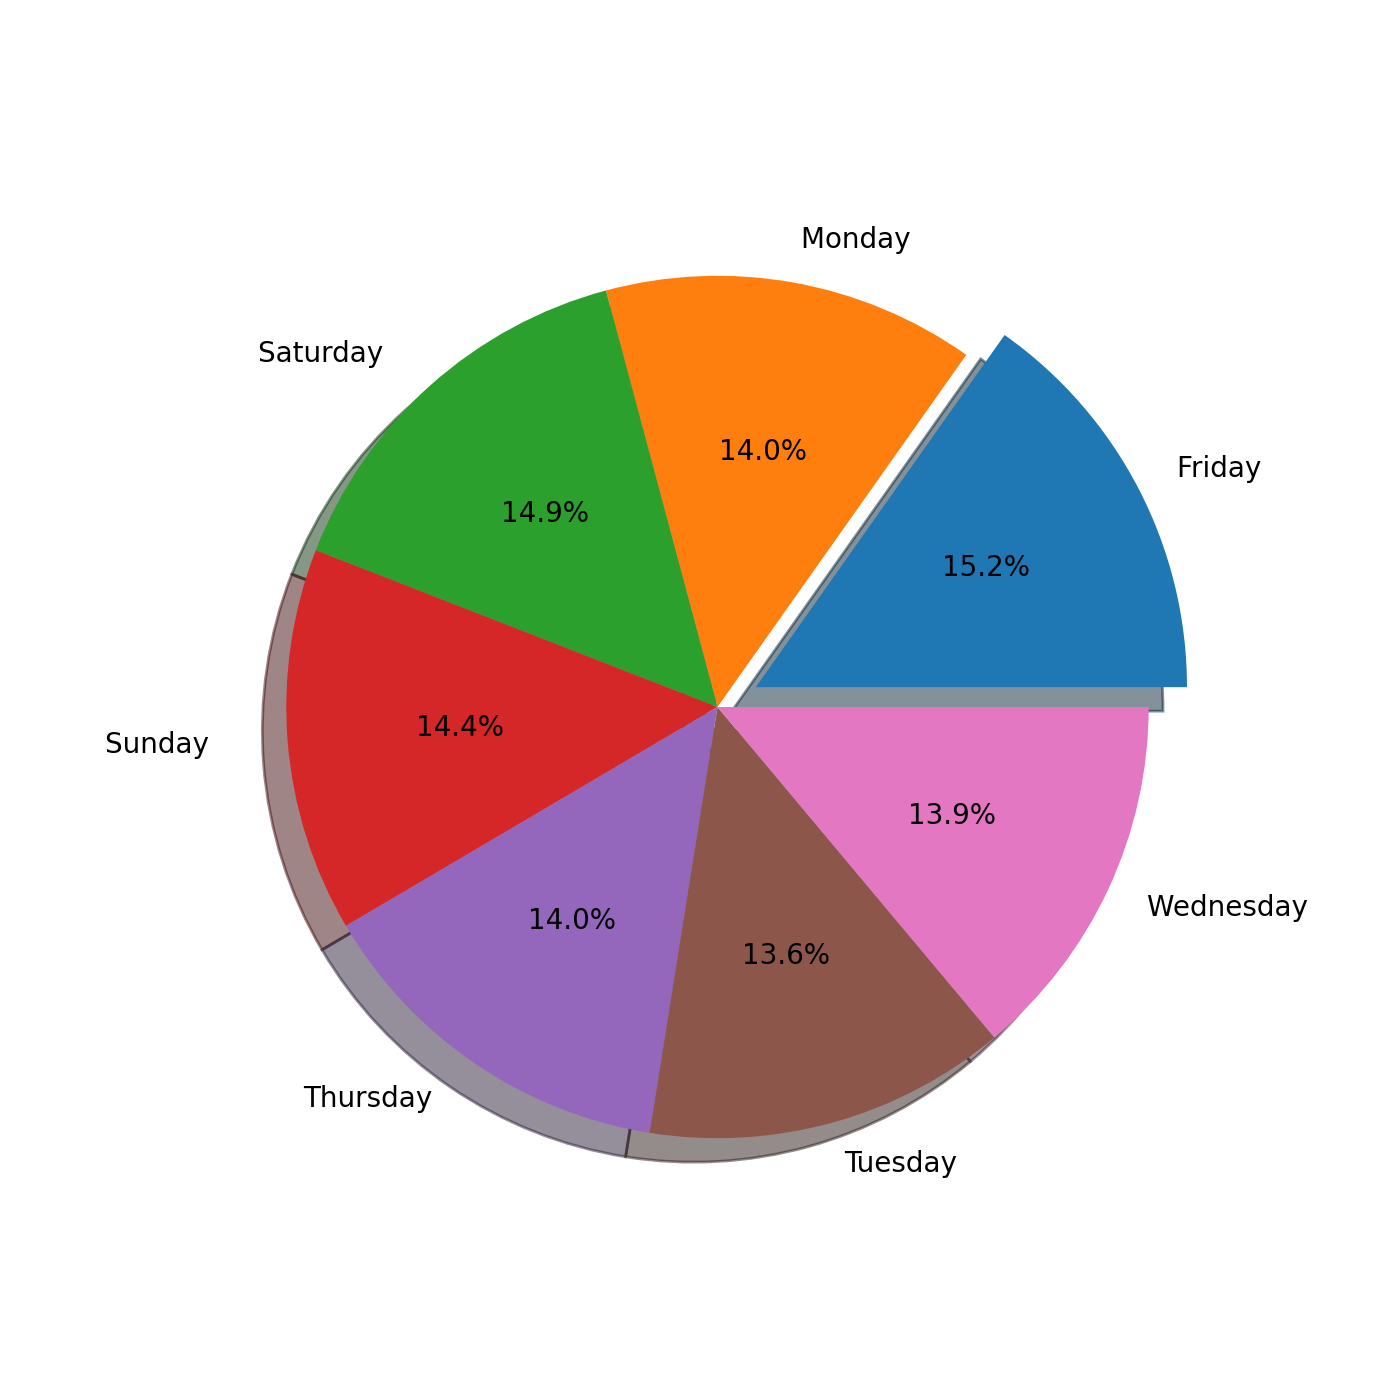

In [20]:
#plot the data
plt.figure(figsize = (7,7))
plt.pie(x = crime_day['percentage'], labels = crime_day['occurrencedayofweek'], explode = [0.1,0,0,0,0,0,0], shadow = True, autopct = '%1.1f%%')
plt.show()

In [21]:
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205321 entries, 0 to 206434
Data columns (total 81 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   event_unique_id          205321 non-null  object             
 1   occurrencedate           205321 non-null  datetime64[ns, UTC]
 2   reporteddate             205321 non-null  datetime64[ns, UTC]
 3   premisetype              205321 non-null  object             
 4   offence                  205321 non-null  object             
 5   reportedyear             205321 non-null  int64              
 6   reportedmonth            205321 non-null  object             
 7   reportedday              205321 non-null  int64              
 8   reporteddayofyear        205321 non-null  int64              
 9   reporteddayofweek        205321 non-null  object             
 10  reportedhour             205321 non-null  int64              
 11  occurrenceyea

In [22]:
#grouby the data for different neighbourhood of the toronto
crime_neighbour = df_crime[['Neighbourhood','event_unique_id','PopDen','occurrenceyear']].groupby(['Neighbourhood','PopDen','occurrenceyear']).count().reset_index()
crime_neighbour

Neighbourhood  PopDen  occurrenceyear  event_unique_id
0      Agincourt North (129)  3929.0          2014.0              175
1      Agincourt North (129)  3929.0          2015.0              188
2      Agincourt North (129)  3929.0          2016.0              160
3      Agincourt North (129)  3929.0          2017.0              184
4      Agincourt North (129)  3929.0          2018.0              237
..                       ...     ...             ...              ...
835  Yorkdale-Glen Park (31)  2451.0          2015.0              277
836  Yorkdale-Glen Park (31)  2451.0          2016.0              334
837  Yorkdale-Glen Park (31)  2451.0          2017.0              330
838  Yorkdale-Glen Park (31)  2451.0          2018.0              363
839  Yorkdale-Glen Park (31)  2451.0          2019.0              416

[840 rows x 4 columns]

In [23]:
df_crime.columns

Index(['event_unique_id', 'occurrencedate', 'reporteddate', 'premisetype',
       'offence', 'reportedyear', 'reportedmonth', 'reportedday',
       'reporteddayofyear', 'reporteddayofweek', 'reportedhour',
       'occurrenceyear', 'occurrencemonth', 'occurrenceday',
       'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour', 'MCI',
       'Hood_ID', 'Neighbourhood', 'Lat', 'Long', 'OBJECTID', 'Population',
       'Assault_2014', 'Assault_2015', 'Assault_2016', 'Assault_2017',
       'Assault_2018', 'Assault_2019', 'Assault_AVG', 'Assault_CHG',
       'Assault_Rate_2019', 'AutoTheft_2014', 'AutoTheft_2015',
       'AutoTheft_2016', 'AutoTheft_2017', 'AutoTheft_2018', 'AutoTheft_2019',
       'AutoTheft_AVG', 'AutoTheft_CHG', 'AutoTheft_Rate_2019',
       'BreakandEnter_2014', 'BreakandEnter_2015', 'BreakandEnter_2016',
       'BreakandEnter_2017', 'BreakandEnter_2018', 'BreakandEnter_2019',
       'BreakandEnter_AVG', 'BreakandEnter_CHG', 'BreakandEnter_Rate_2019',
       'Ho

In [24]:
crime_neighbour.loc[:,'Neighbourhood'] = crime_neighbour.loc[:,'Neighbourhood'].str.replace('\(\d+\)','')
crime_neighbour

Neighbourhood  PopDen  occurrenceyear  event_unique_id
0       Agincourt North   3929.0          2014.0              175
1       Agincourt North   3929.0          2015.0              188
2       Agincourt North   3929.0          2016.0              160
3       Agincourt North   3929.0          2017.0              184
4       Agincourt North   3929.0          2018.0              237
..                   ...     ...             ...              ...
835  Yorkdale-Glen Park   2451.0          2015.0              277
836  Yorkdale-Glen Park   2451.0          2016.0              334
837  Yorkdale-Glen Park   2451.0          2017.0              330
838  Yorkdale-Glen Park   2451.0          2018.0              363
839  Yorkdale-Glen Park   2451.0          2019.0              416

[840 rows x 4 columns]

<IPython.core.display.Javascript object>


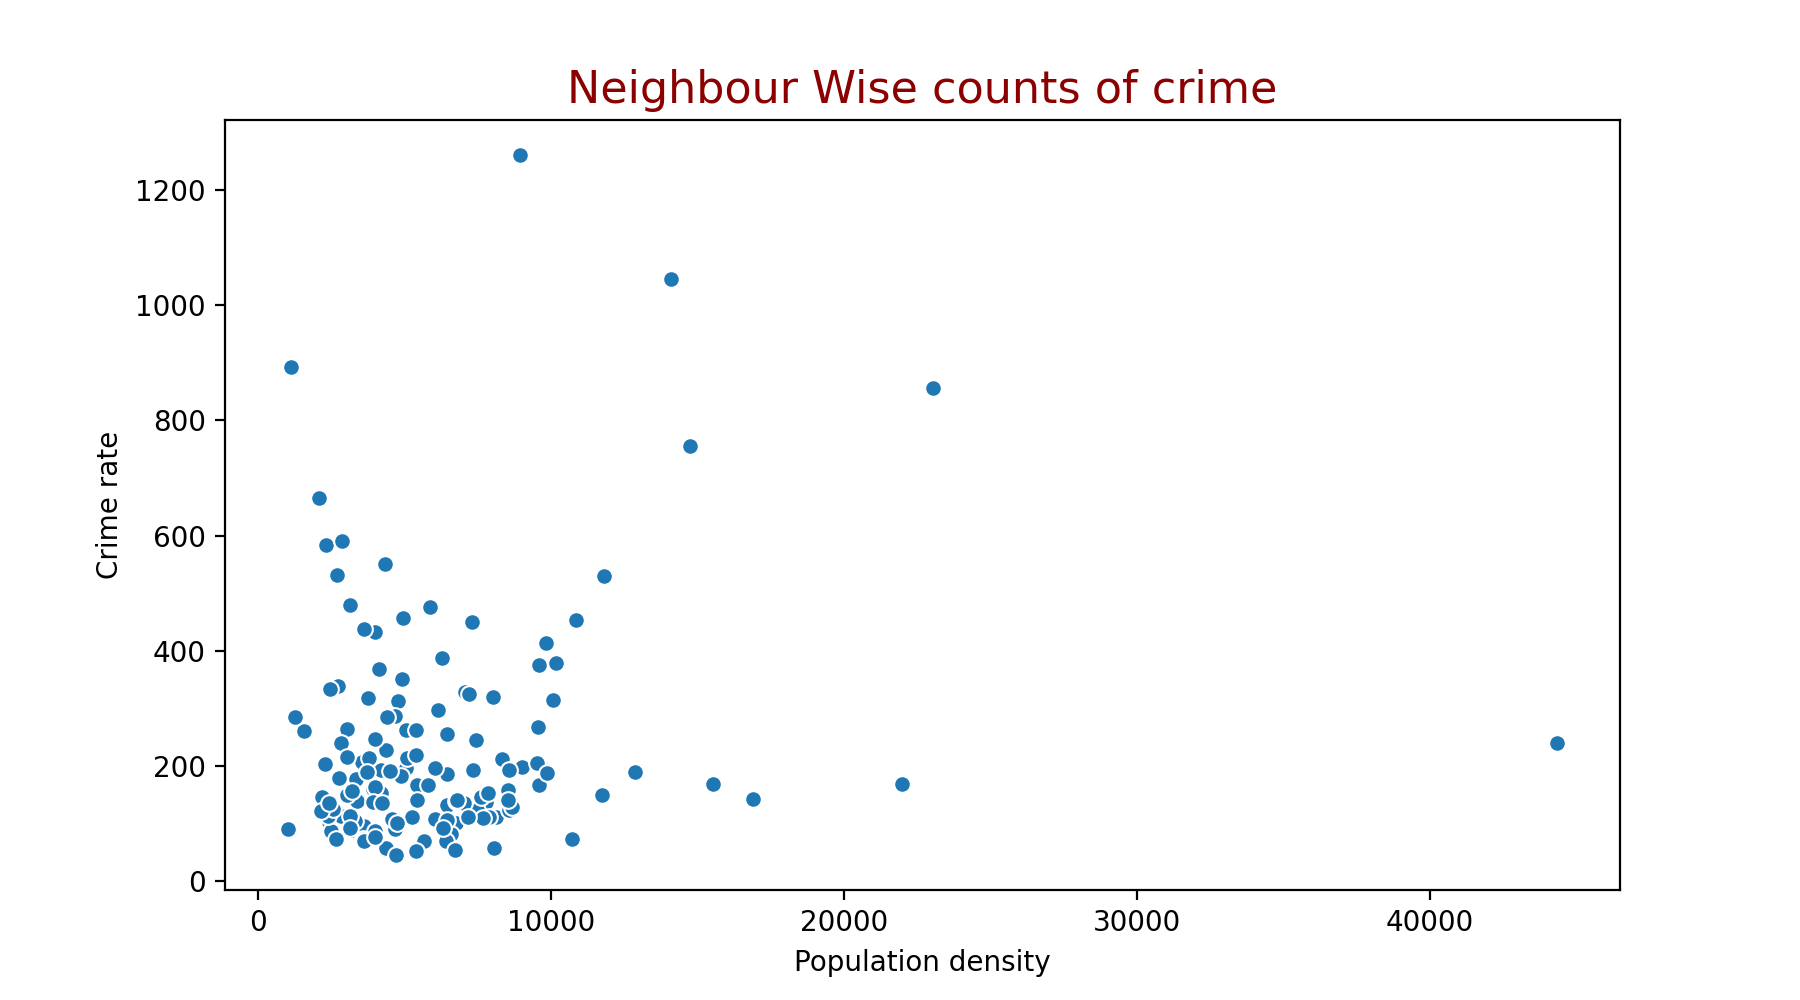

In [25]:
plt.figure(figsize = [9,5])
sns.scatterplot(x = 'PopDen', y = 'event_unique_id', data = crime_neighbour[crime_neighbour.occurrenceyear==2016])
plt.xlabel('Population density')
plt.ylabel('Crime rate')
plt.title('Neighbour Wise counts of crime', fontdict = {'color': 'darkred', 'size':16})
plt.show()

<IPython.core.display.Javascript object>


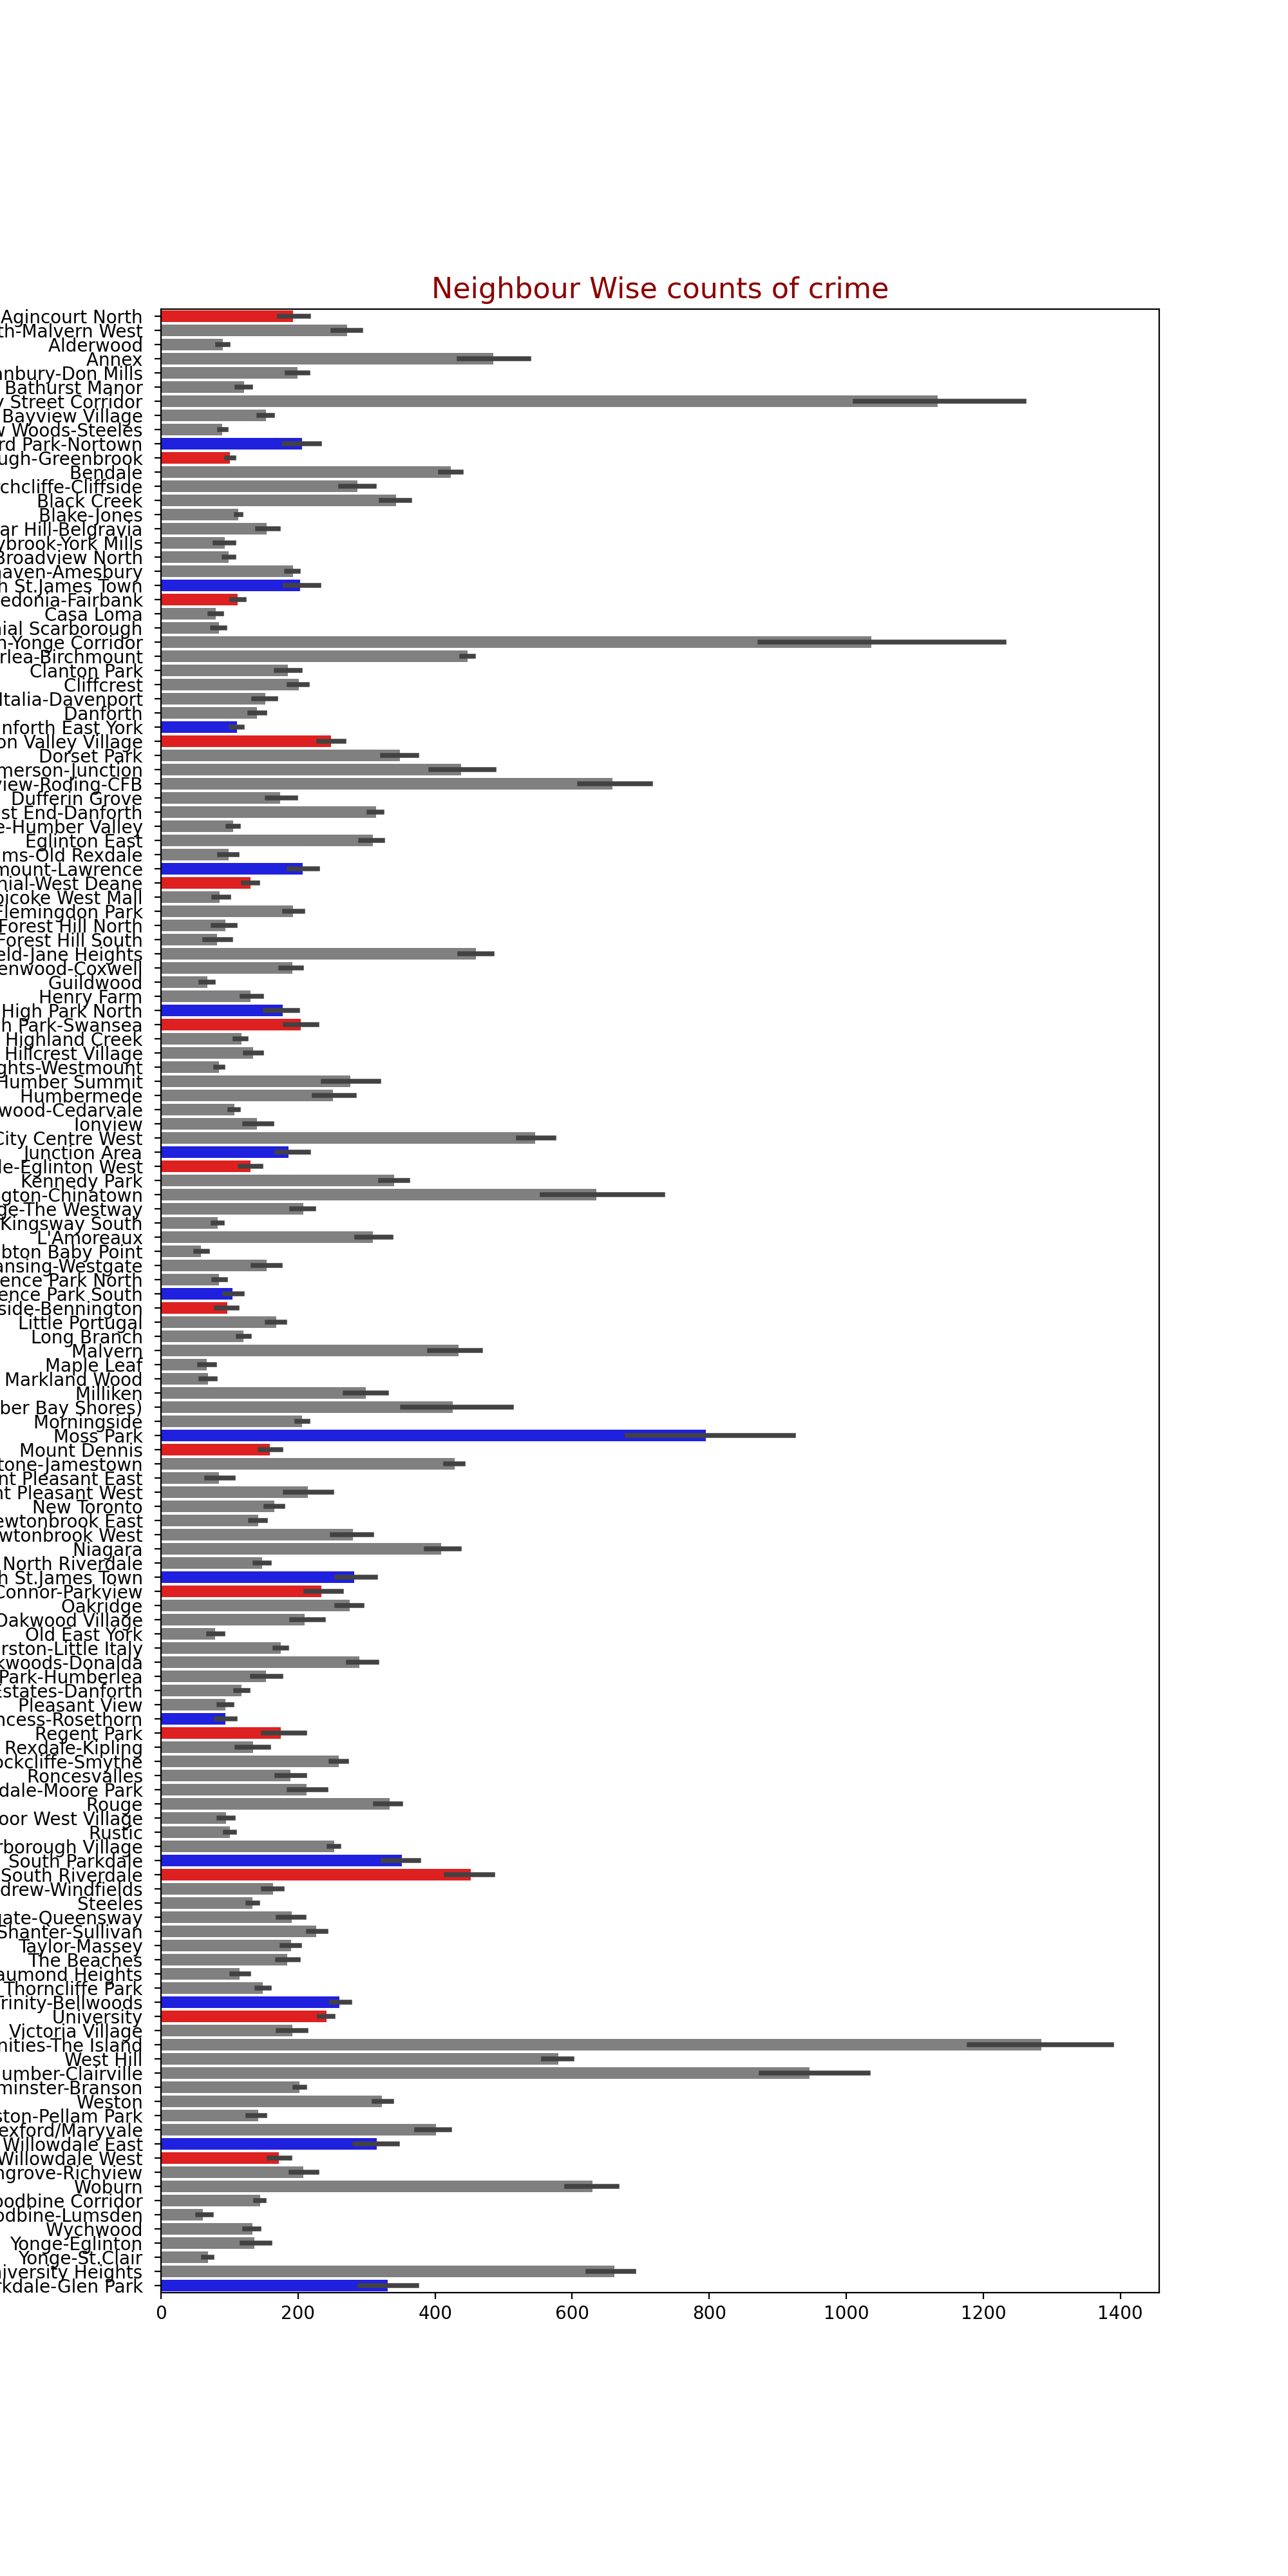

In [26]:
#plot the data for the different neighbourhoods of Toronto
plt.figure(figsize = [10,20])
sns.barplot(x = 'event_unique_id',y = crime_neighbour['Neighbourhood'], data = crime_neighbour, palette = ['red']+['grey']*8+['blue'])
plt.xlabel('')
plt.ylabel('Count')
plt.title('Neighbour Wise counts of crime', fontdict = {'color': 'darkred', 'size':16})
plt.show()

In [27]:
crime_type = df_crime[['offence','event_unique_id']].groupby('offence').count().reset_index()
crime_type.head()

offence  event_unique_id
0     Administering Noxious Thing              293
1   Aggravated Aslt Peace Officer               12
2              Aggravated Assault             1848
3  Aggravated Assault Avails Pros               13
4  Air Gun Or Pistol: Bodily Harm               20

In [28]:
#groupby the data with the years
crime_year = df_crime[['occurrenceyear','event_unique_id']].groupby('occurrenceyear').count().reset_index()
crime_year

occurrenceyear  event_unique_id
0          2014.0            31638
1          2015.0            32316
2          2016.0            32809
3          2017.0            34561
4          2018.0            36323
5          2019.0            37674

In [29]:
crime_byDay = df_crime[['occurrencedate','event_unique_id']].groupby('occurrencedate').count().reset_index()
crime_byDay

occurrencedate  event_unique_id
0    2014-01-01 05:00:00+00:00              214
1    2014-01-02 05:00:00+00:00               53
2    2014-01-03 05:00:00+00:00               65
3    2014-01-04 05:00:00+00:00               59
4    2014-01-05 05:00:00+00:00               72
...                        ...              ...
2186 2019-12-27 05:00:00+00:00               89
2187 2019-12-28 05:00:00+00:00              103
2188 2019-12-29 05:00:00+00:00               79
2189 2019-12-30 05:00:00+00:00               59
2190 2019-12-31 05:00:00+00:00               65

[2191 rows x 2 columns]

<IPython.core.display.Javascript object>


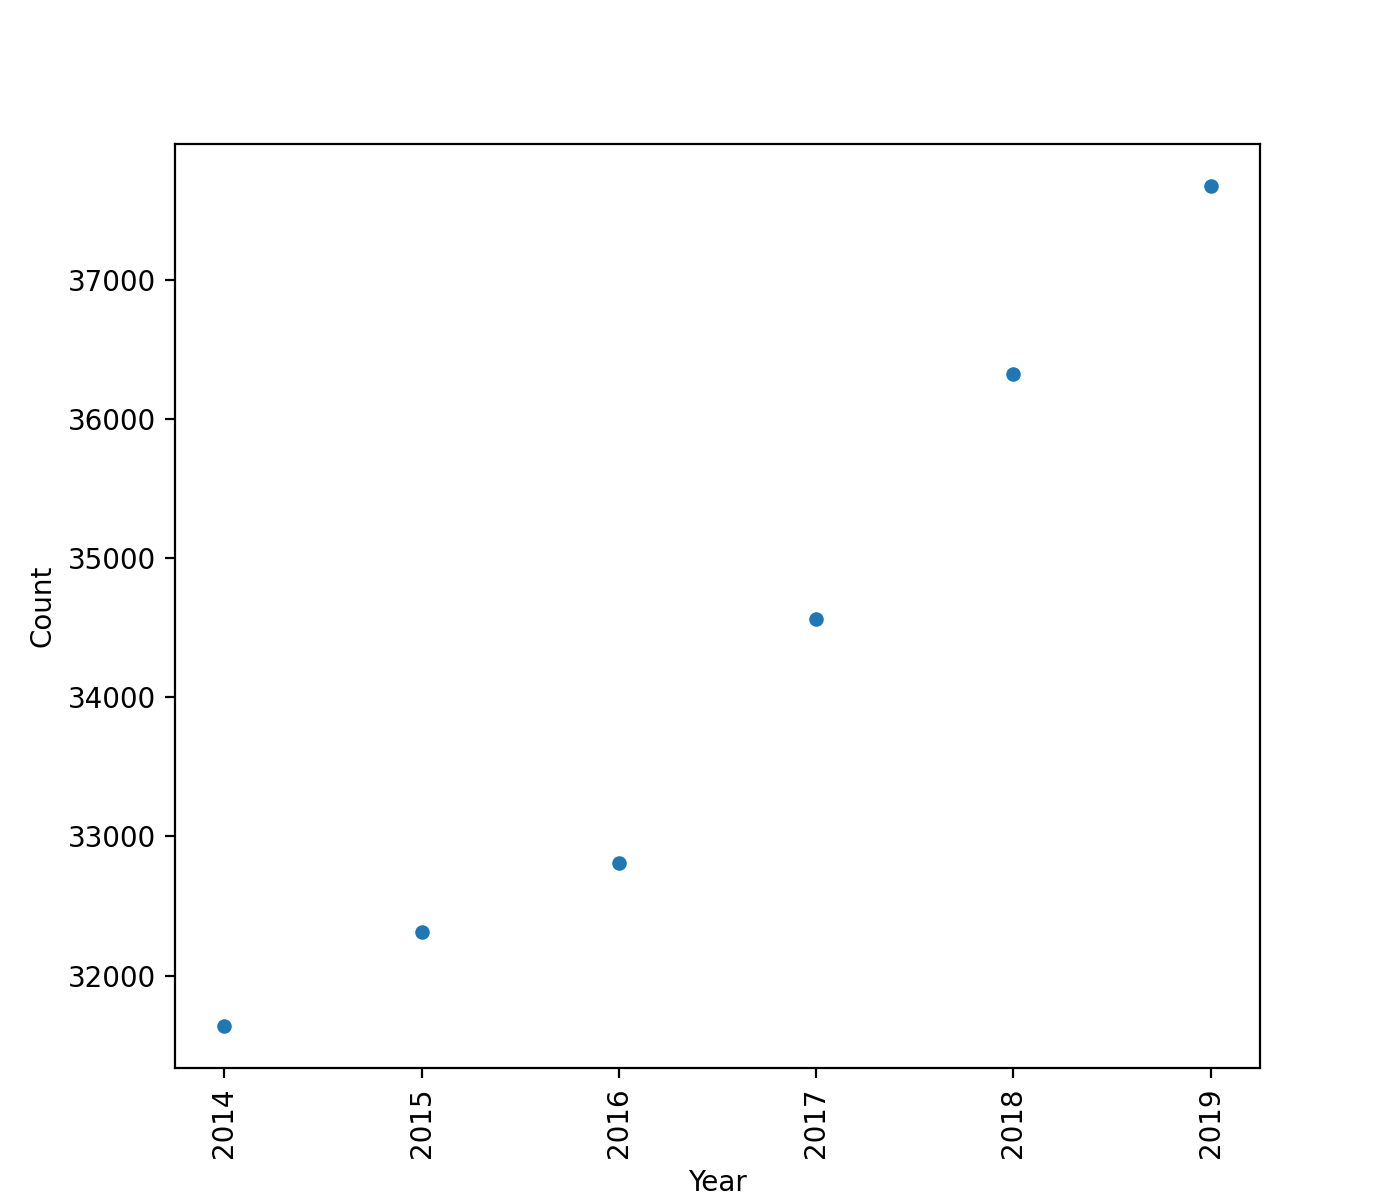

In [30]:
#Plot the data
plt.figure(figsize = [7,6])
sns.scatterplot(x = 'occurrenceyear', y = 'event_unique_id' , data = crime_year)
plt.xlabel('Year')
plt.ylabel('Count')
#plt.title('occurrenceyear', fontdict = {'color': 'darkred', 'size':16})
plt.xticks(rotation = 90)
plt.show()

<IPython.core.display.Javascript object>


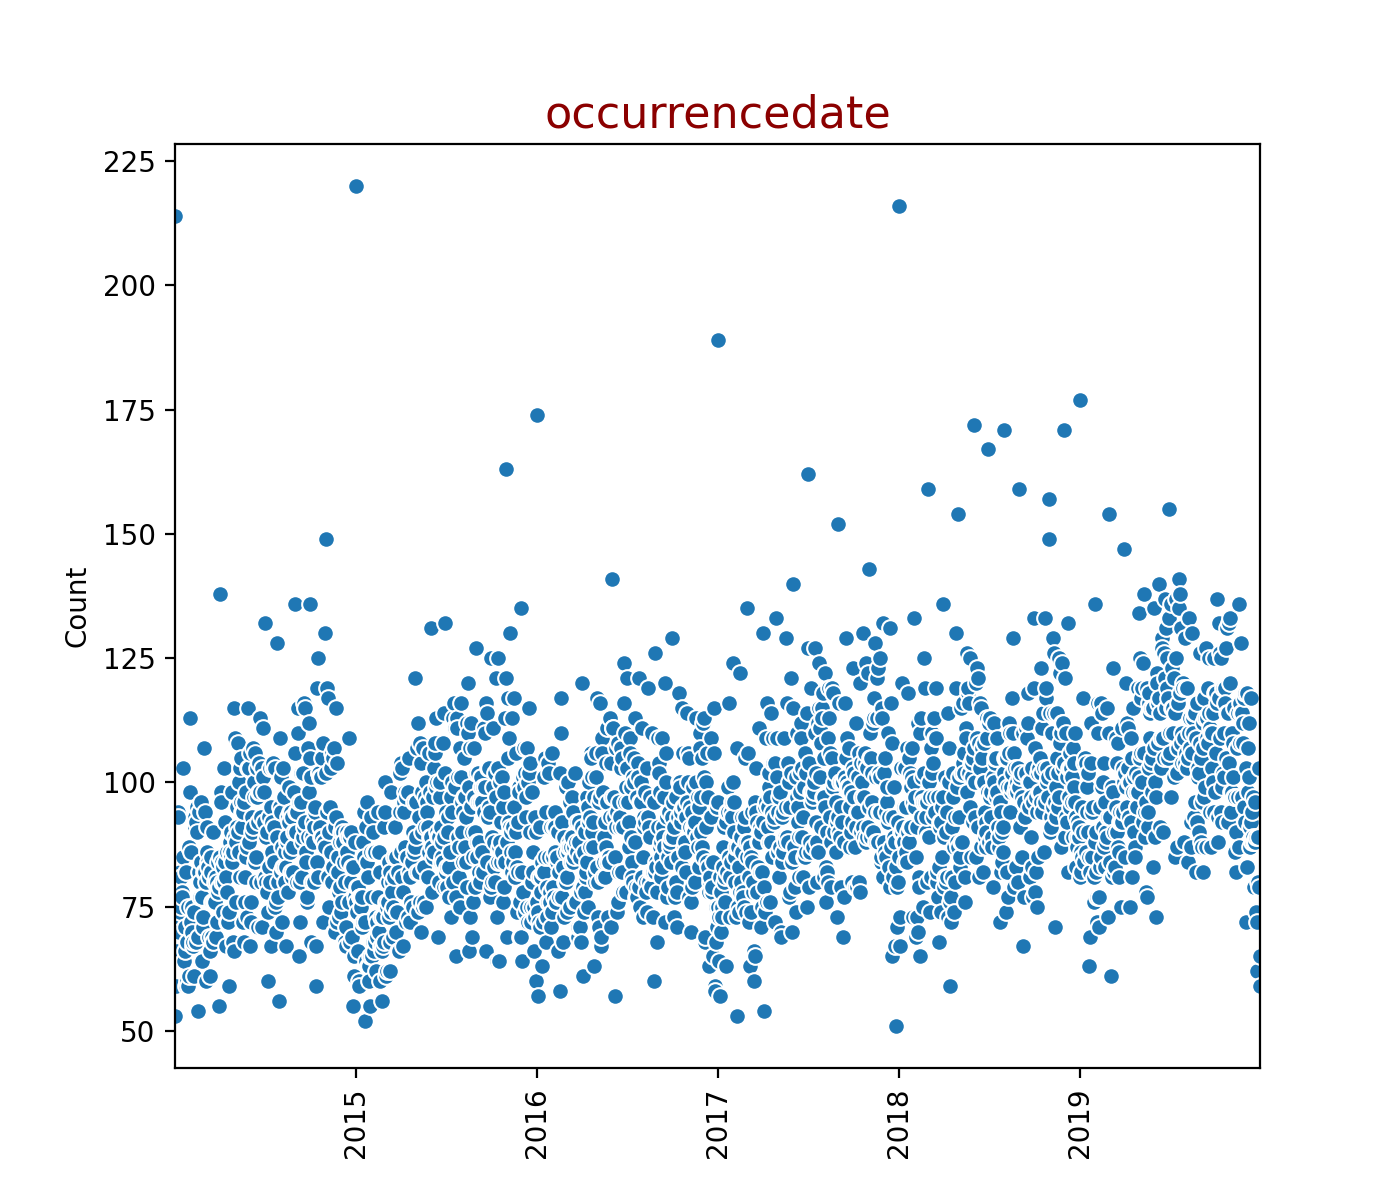

In [31]:
plt.figure(figsize = [7,6])
sns.scatterplot(x = 'occurrencedate', y = 'event_unique_id' , data = crime_byDay)
plt.xlabel('')
plt.ylabel('Count')
plt.title('occurrencedate', fontdict = {'color': 'darkred', 'size':16})
plt.xticks(rotation = 90)
plt.xlim((crime_byDay.occurrencedate.min(),crime_byDay.occurrencedate.max()))
plt.show()

In [32]:
#calculate the crime rate for the month
crime_month = df_crime[['occurrencemonth','event_unique_id']].groupby('occurrencemonth').count().reset_index()
crime_month.head()

occurrencemonth  event_unique_id
0           April            16431
1          August            17833
2        December            16590
3        February            14457
4         January            16087

<IPython.core.display.Javascript object>


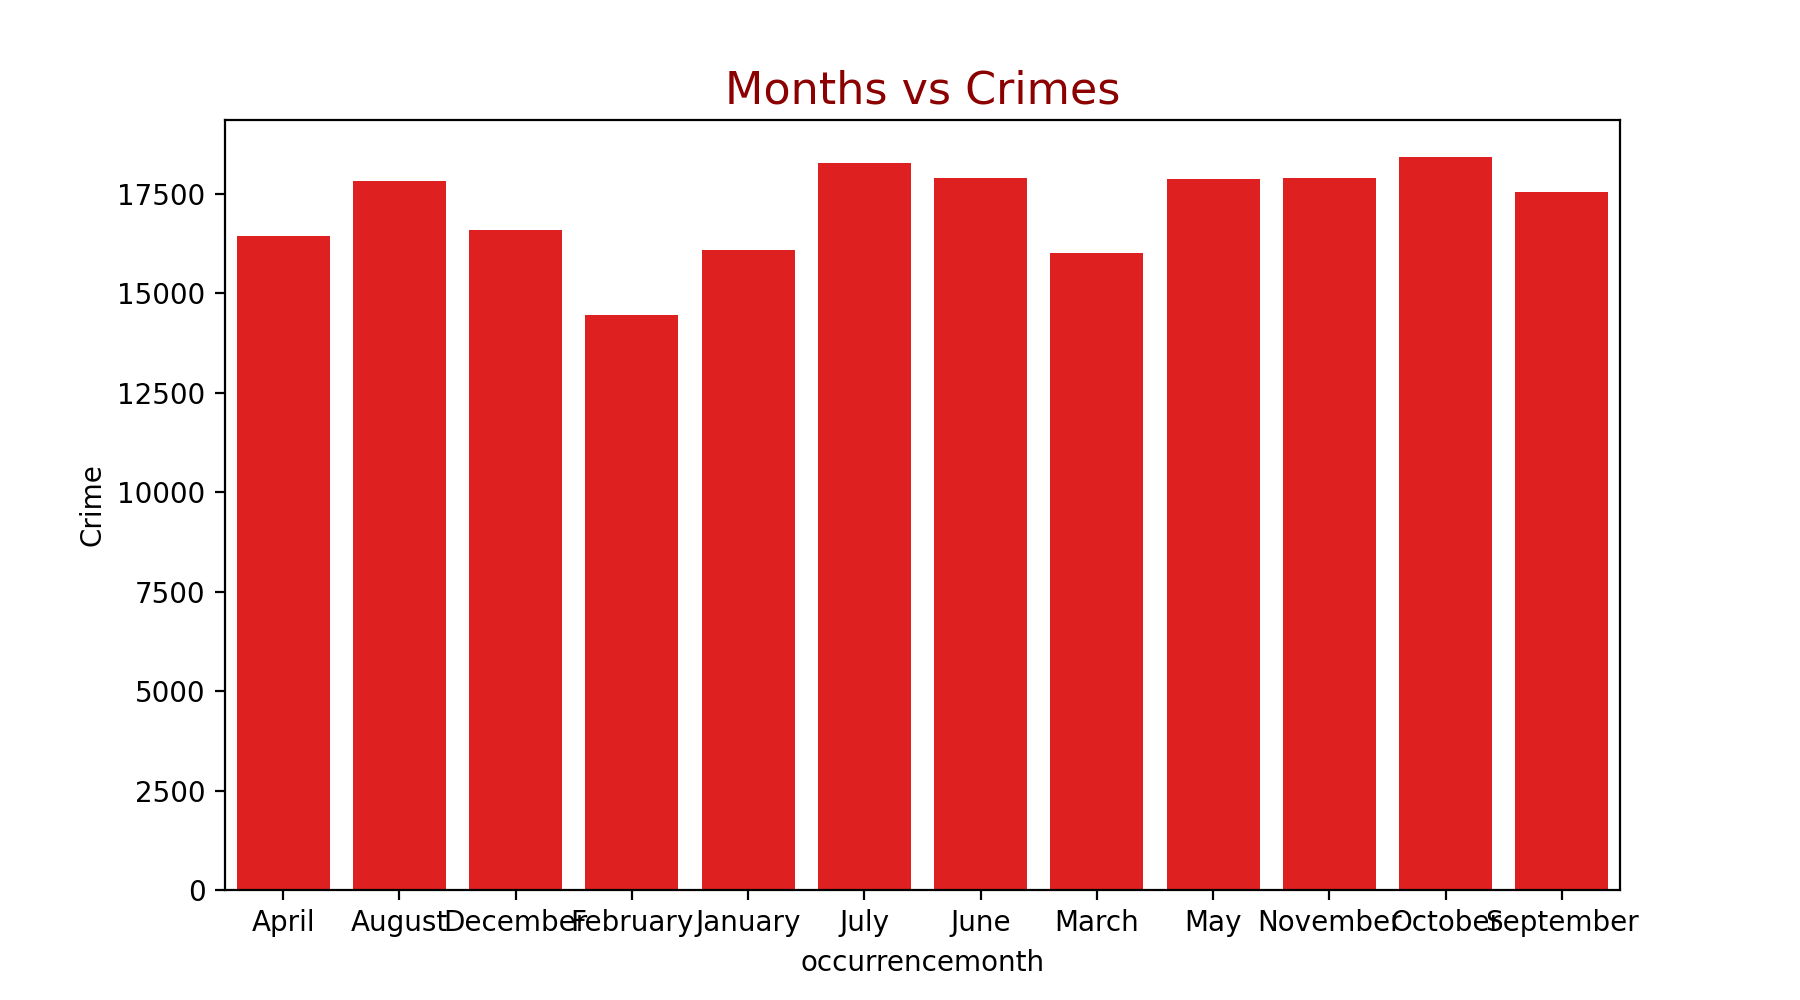

Text(0, 0.5, 'Crime')

In [33]:
#plot the data
plt.figure(figsize = (9,5))
sns.barplot(x = crime_month['occurrencemonth'], y = 'event_unique_id', data = crime_month, color = 'red')
plt.title('Months vs Crimes', fontdict = {'color': 'darkred', 'size':16})
plt.ylabel('Crime')

In [34]:
#generate a feature to calculate crime for the part of a day
def PartofDay(a):
    if a in [23,0,1,2]:
        return 'Midnight'
    elif a in [3,4,5,6]:
        return 'Early Morning'
    elif a in [7,8,9,10]:
        return 'Morning'
    elif a in [11,12,13,14]:
        return 'Noon'
    elif a in [15,16,17,18]:
        return 'Evening'
    else:
        return 'Night'



In [35]:
df_crime['PartofDay'] = df_crime.occurrencehour.apply(PartofDay)

In [36]:
crime_PartofDay = df_crime[['PartofDay','event_unique_id']].groupby('PartofDay').count().reset_index()
crime_PartofDay

PartofDay  event_unique_id
0  Early Morning            19023
1        Evening            41195
2       Midnight            41283
3        Morning            24753
4          Night            43333
5           Noon            35734

<IPython.core.display.Javascript object>


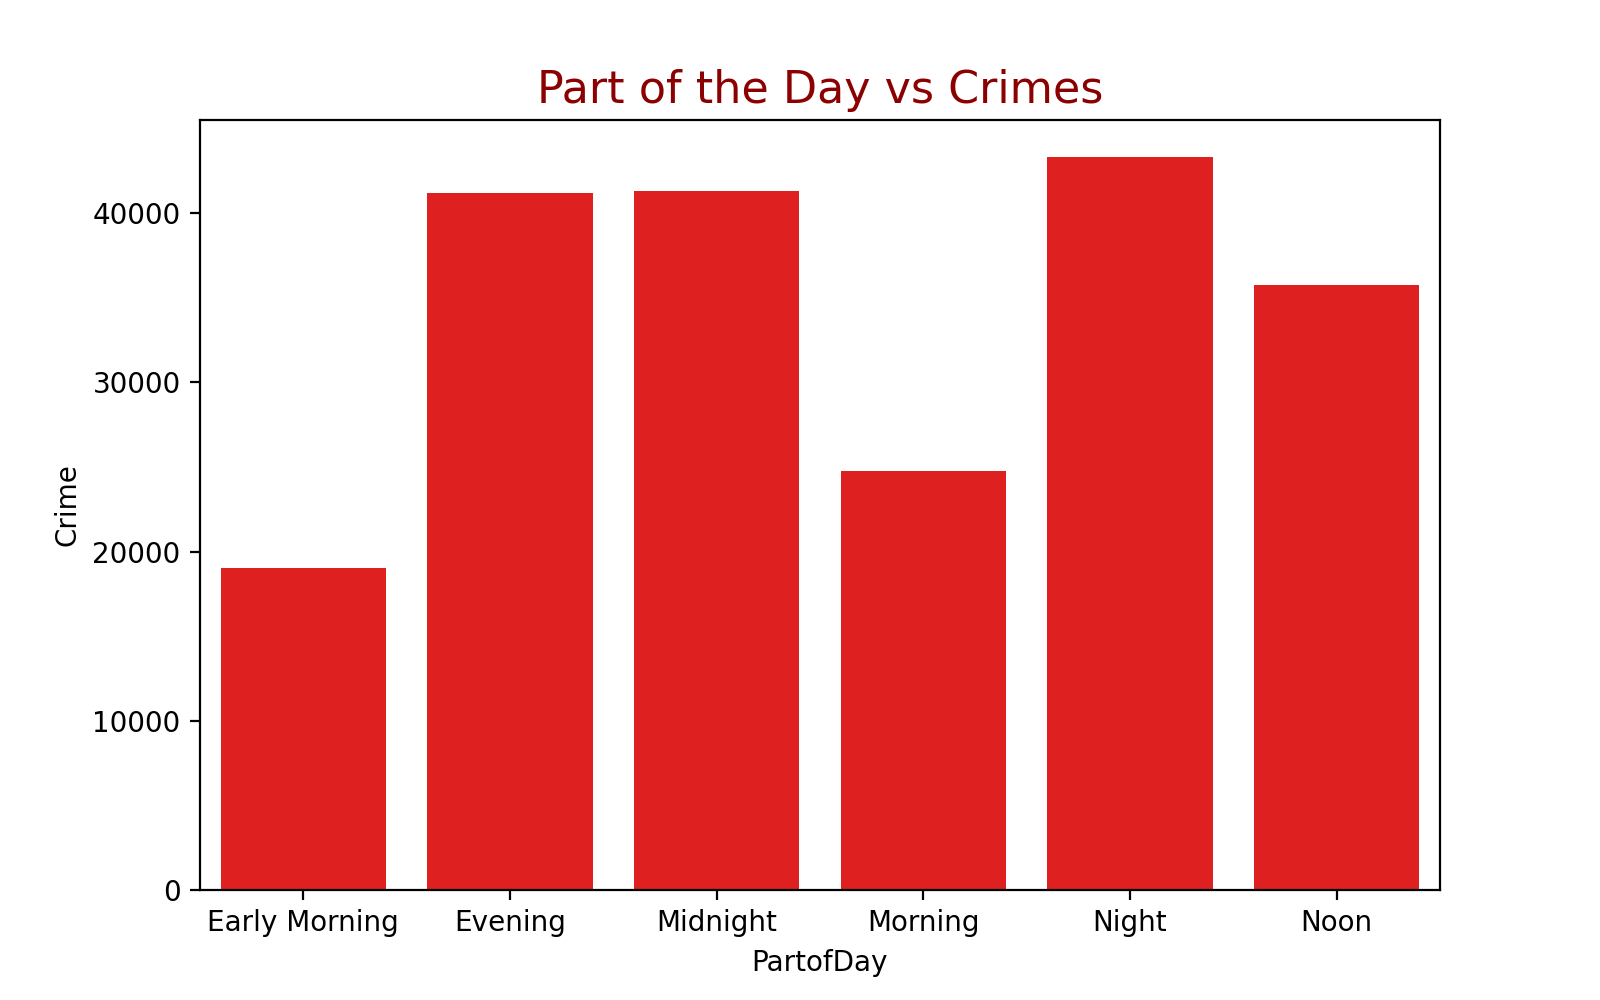

Text(0, 0.5, 'Crime')

In [37]:
plt.figure(figsize = (8,5))
sns.barplot(x = crime_PartofDay['PartofDay'], y = 'event_unique_id', data = crime_PartofDay, color = 'red')
plt.title('Part of the Day vs Crimes', fontdict = {'color': 'darkred', 'size':16})
plt.ylabel('Crime')

<IPython.core.display.Javascript object>


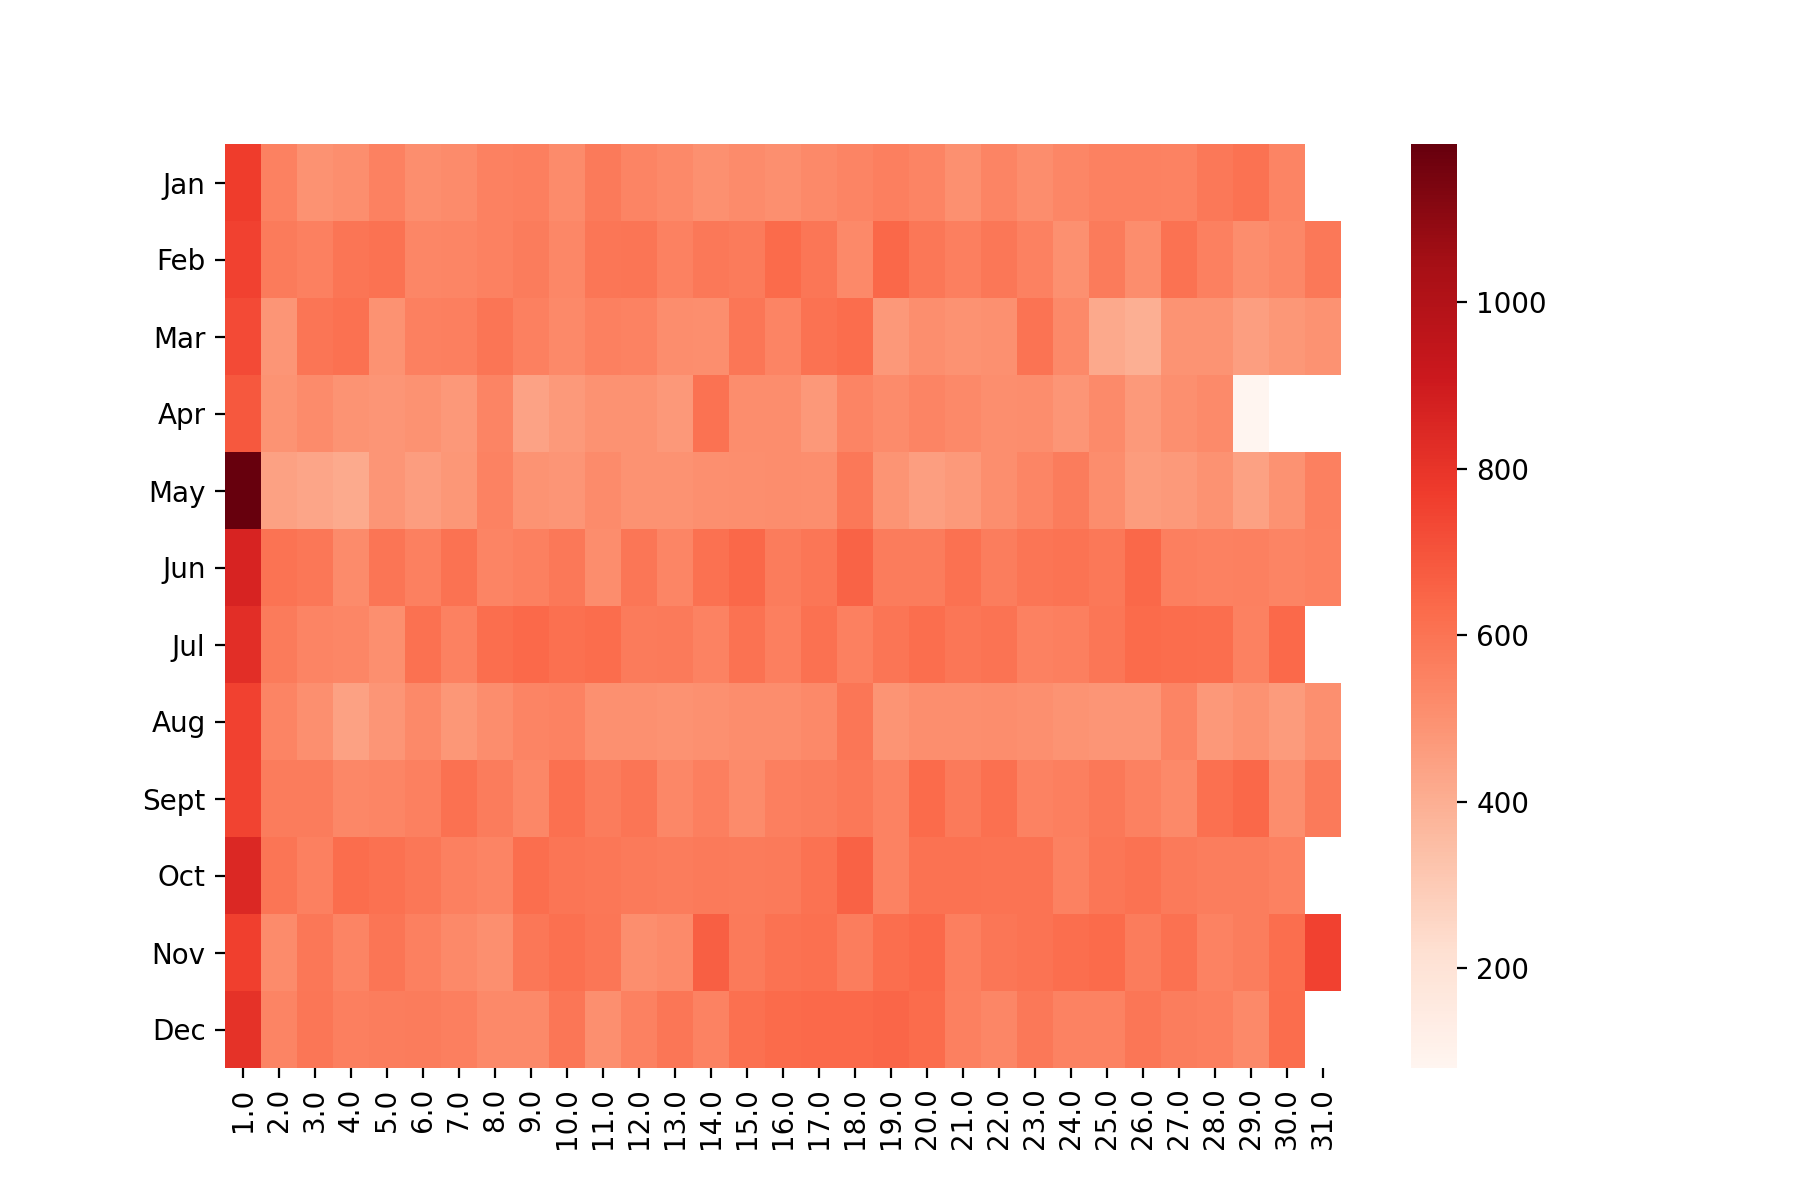

In [38]:
#heatmap for month and day of the month
crime_day_month = pd.pivot_table(columns = df_crime.occurrenceday, values = 'occurrenceday' ,index = 'occurrencemonth',
                                 aggfunc = 'count', data = df_crime)
plt.figure(figsize = (9,6))
sns.heatmap(crime_day_month, cmap = 'Reds')
plt.yticks(np.arange(0.5,12.5) ,['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'])
plt.xlabel('')
plt.ylabel('')
plt.show()

In [39]:
df_crime[(df_crime.occurrencemonth =='May') & (df_crime.occurrenceday == 2)].groupby('occurrenceyear').count()

event_unique_id  occurrencedate  reporteddate  premisetype  \
occurrenceyear                                                               
2014.0                      109             109           109          109   
2015.0                       89              89            89           89   
2016.0                       83              83            83           83   
2017.0                       94              94            94           94   
2018.0                       93              93            93           93   
2019.0                      105             105           105          105   

                offence  reportedyear  reportedmonth  reportedday  \
occurrenceyear                                                      
2014.0              109           109            109          109   
2015.0               89            89             89           89   
2016.0               83            83             83           83   
2017.0               94            94             94           94   
2018.0               93            93             93           93   
2019.0              105           105            105          105   

                reporteddayofyear  reporteddayofweek  ...  TheftOver_2017  \
occurrenceyear                                        ...                   
2014.0                        109                109  ...             109   
2015.0                         89                 89  ...              89   
2016.0                         83                 83  ...              83   
2017.0                         94                 94  ...              94   
2018.0                         93                 93  ...              93   
2019.0                        105                105  ...             105   

                TheftOver_2018  TheftOver_2019  TheftOver_AVG  TheftOver_CHG  \
occurrenceyear                                                                 
2014.0                     109             109            109            109   
2015.0                      89              89             89             89   
2016.0                      83              83             83             83   
2017.0                      94              94             94             94   
2018.0                      93              93             93             93   
2019.0                     105             105            105            105   

                TheftOver_Rate_2019  Shape__Area  Shape__Length  PopDen  \
occurrenceyear                                                            
2014.0                          109          109            109     109   
2015.0                           89           89             89      89   
2016.0                           83           83             83      83   
2017.0                           94           94             94      94   
2018.0                           93           93             93      93   
2019.0                          105          105            105     105   

                PartofDay  
occurrenceyear             
2014.0                109  
2015.0                 89  
2016.0                 83  
2017.0                 94  
2018.0                 93  
2019.0                105  

[6 rows x 81 columns]

In [40]:
group_list = ["occurrencedate", "premisetype", "offence", "occurrenceyear", "occurrencemonth", "occurrenceday", 
              "Population", "occurrencedayofweek", "occurrencehour", "MCI", "Hood_ID", "Neighbourhood", 
              "Long", "Lat"]
df_crime.groupby(group_list).count()

event_unique_id  \
occurrencedate            premisetype offence                occurrenceyear occurrencemonth occurrenceday Population occurrencedayofweek occurrencehour MCI        Hood_ID Neighbourhood                 Long    Lat                          
2014-01-01 05:00:00+00:00 Apartment   Aggravated Assault     2014.0         January         1.0           7804       Wednesday           0              Assault    67      Playter Estates-Danforth (67) -79.362 43.681229                1   
                                      Assault                2014.0         January         1.0           7727       Wednesday           9              Assault    69      Blake-Jones (69)              -79.340 43.676651                1   
                                                                                                          7804       Wednesday           0              Assault    67      Playter Estates-Danforth (67) -79.362 43.681229                1   
                                                                                                          11098      Wednesday           0              Assault    91      Weston-Pellam Park (91)       -79.457 43.670212                1   
                                                                                                          11785      Wednesday           1              Assault    83      Dufferin Grove (83)           -79.431 43.660793                1   
...                                                                                                                                                                                                                                     ...   
2019-12-31 05:00:00+00:00 Outside     Robbery - Other        2019.0         December        31.0          27392      Tuesday             20             Robbery    136     West Hill (136)               -79.186 43.768410                1   
                                      Robbery With Weapon    2019.0         December        31.0          16828      Tuesday             19             Robbery    56      Leaside-Bennington (56)       -79.362 43.714092                1   
                                                                                                          27593      Tuesday             18             Robbery    27      York University Heights (27)  -79.475 43.786186                1   
                                      Theft Of Motor Vehicle 2019.0         December        31.0          15179      Tuesday             10             Auto Theft 103     Lawrence Park South (103)     -79.415 43.703247                1   
                                                                                                          20923      Tuesday             15             Auto Theft 98      Rosedale-Moore Park (98)      -79.394 43.688084                1   

                                                                                                                                                                                                                            reporteddate  \
occurrencedate            premisetype offence                occurrenceyear occurrencemonth occurrenceday Population occurrencedayofweek occurrencehour MCI        Hood_ID Neighbourhood                 Long    Lat                       
2014-01-01 05:00:00+00:00 Apartment   Aggravated Assault     2014.0         January         1.0           7804       Wednesday           0              Assault    67      Playter Estates-Danforth (67) -79.362 43.681229             1   
                                      Assault                2014.0         January         1.0           7727       Wednesday           9              Assault    69      Blake-Jones (69)              -79.340 43.676651             1   
                                                                                                          7804       Wednesday           0              Assault    67   

<IPython.core.display.Javascript object>


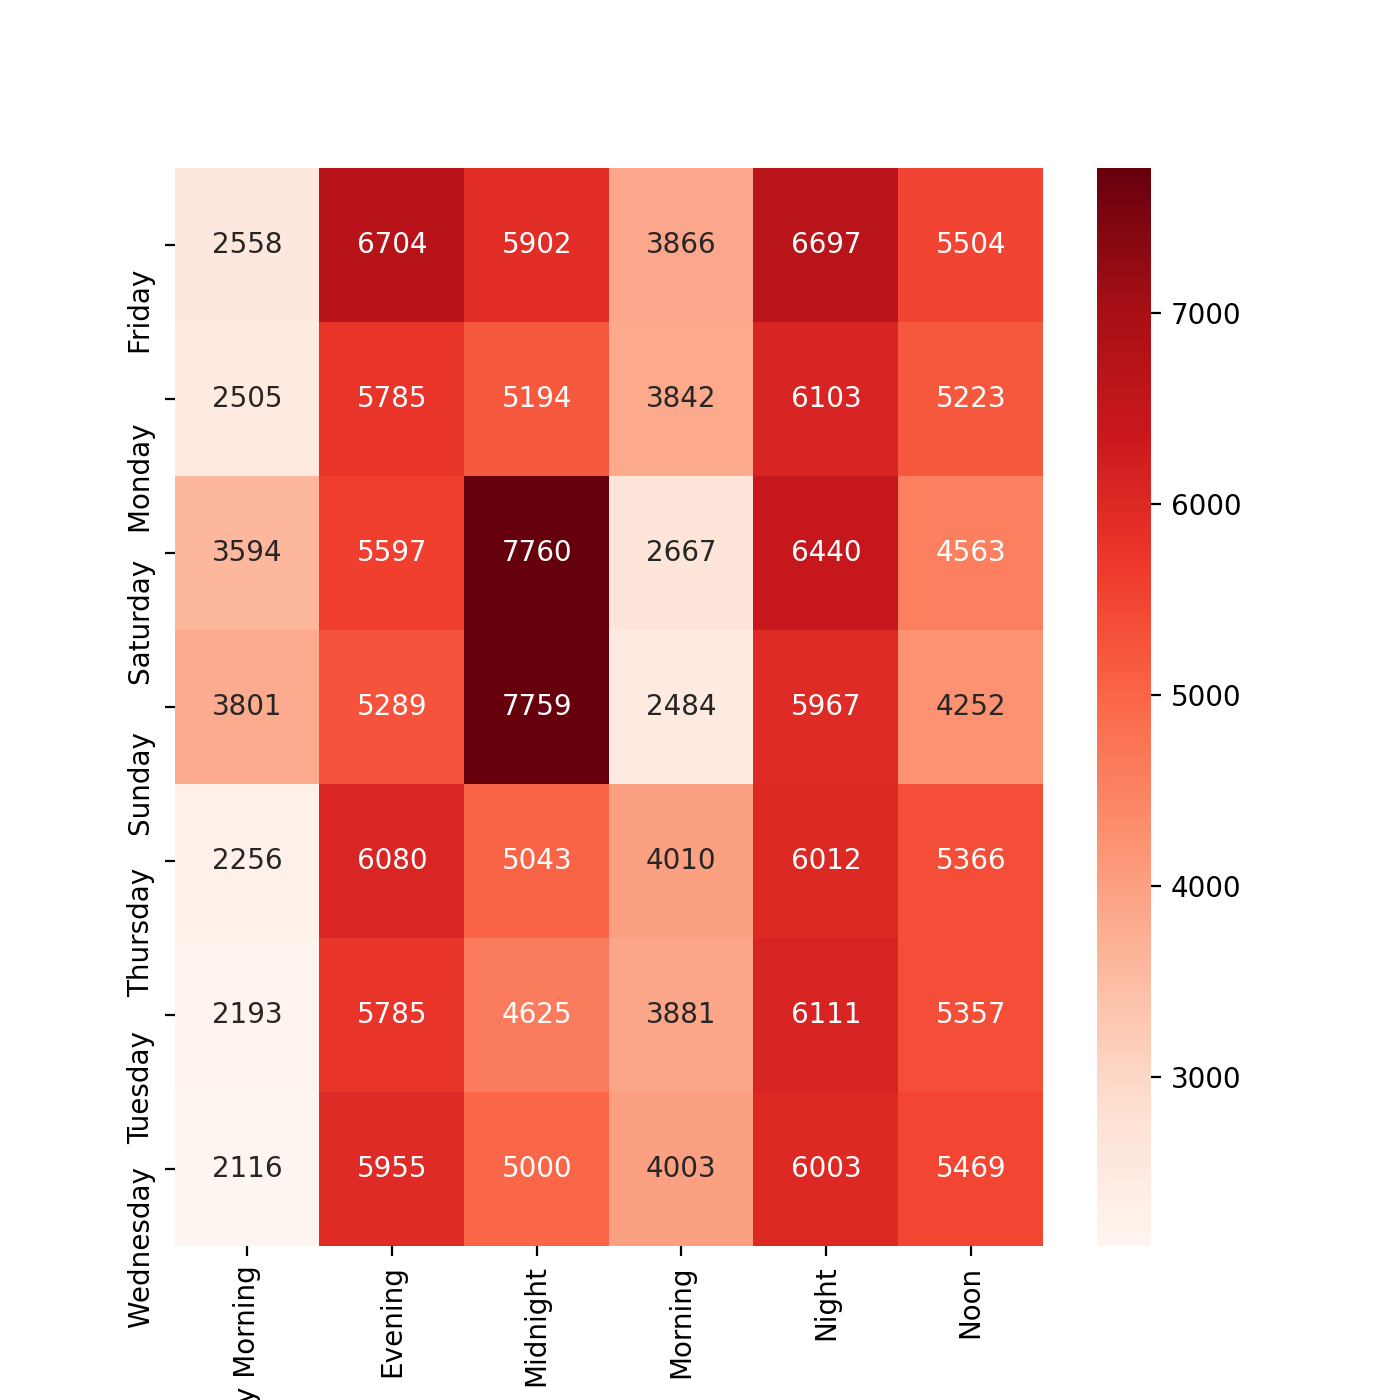

In [41]:
#heatmap for day and part of the day
crime_day_week = pd.pivot_table(columns = df_crime['PartofDay'] ,index = 'occurrencedayofweek',
                                values = 'PartofDay' , aggfunc = 'count', data = df_crime)
#crime_day_week = crime_day_week.reindex(index = ['Friday','Monday','Saturday','Sunday','Thursday','Tuesday','Wednesday'],
#                                        columns = ['Early Morning','Evening','Midnight','Morning','Night','Noon'])
plt.figure(figsize = (7,7))
sns.heatmap(crime_day_week, cmap = 'Reds',annot = True,fmt = 'd')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [42]:
crime_day_week = pd.pivot_table(columns = df_crime['PartofDay'] ,index = 'occurrencedayofweek',
                                values = 'PartofDay' , aggfunc = 'count', data = df_crime)
crime_day_week

PartofDay            Early Morning  Evening  Midnight  Morning  Night  Noon
occurrencedayofweek                                                        
Friday                        2558     6704      5902     3866   6697  5504
Monday                        2505     5785      5194     3842   6103  5223
Saturday                      3594     5597      7760     2667   6440  4563
Sunday                        3801     5289      7759     2484   5967  4252
Thursday                      2256     6080      5043     4010   6012  5366
Tuesday                       2193     5785      4625     3881   6111  5357
Wednesday                     2116     5955      5000     4003   6003  5469

In [43]:
#trend analysis
crime_hour = df_crime.groupby(['MCI', 'occurrencehour']).count()['event_unique_id'].reset_index()
crime_hour.head()

MCI  occurrencehour  event_unique_id
0  Assault               0             6854
1  Assault               1             4921
2  Assault               2             5319
3  Assault               3             3394
4  Assault               4             2082

<IPython.core.display.Javascript object>


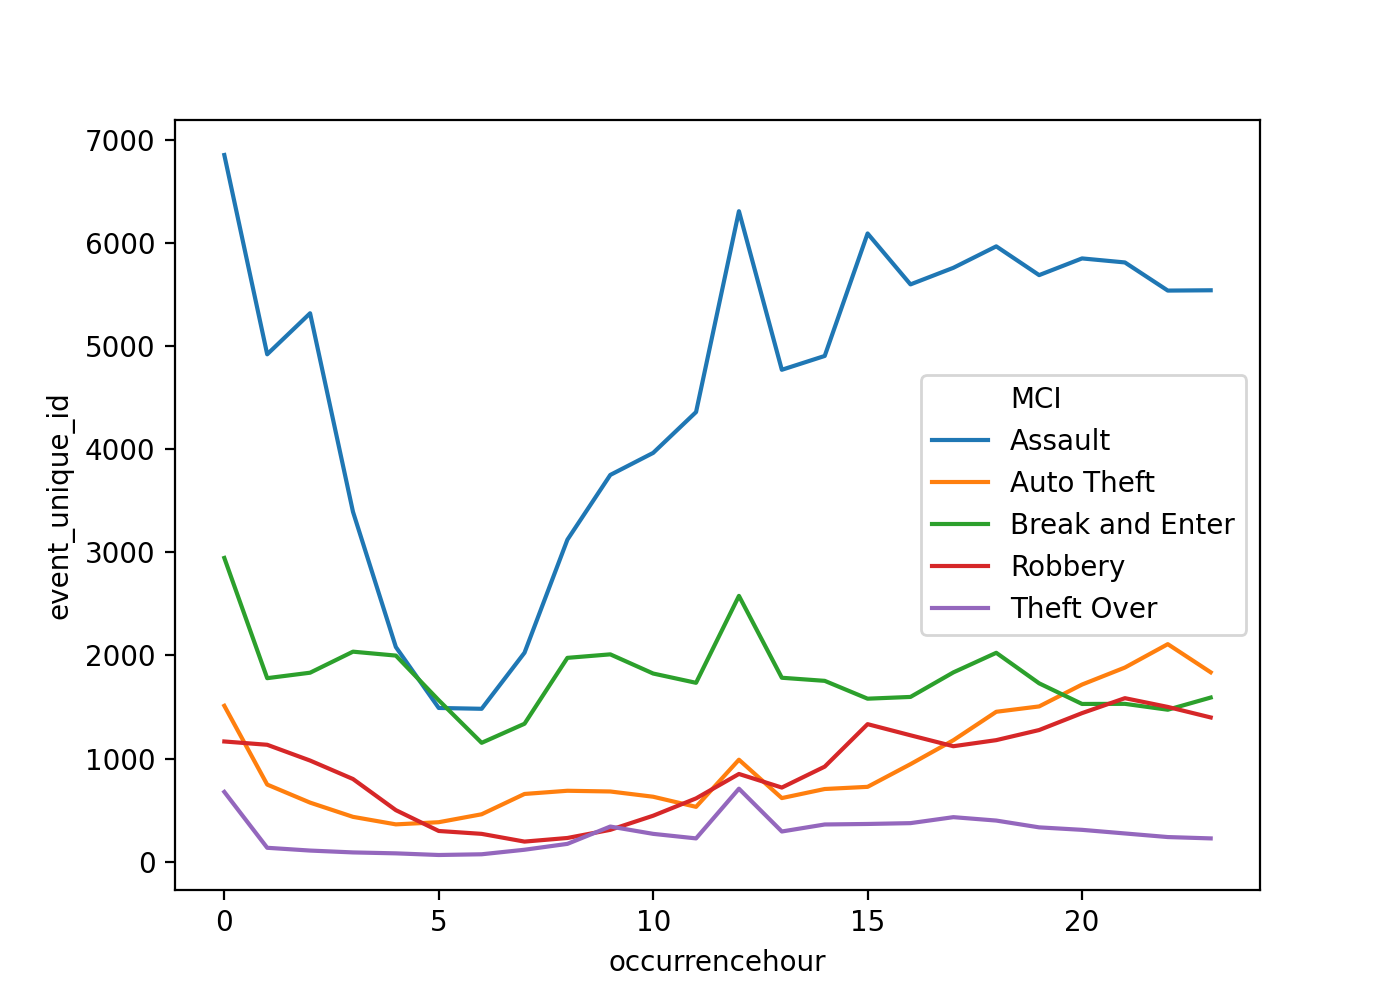

In [44]:
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(x = 'occurrencehour', y= 'event_unique_id', data = crime_hour, ax=ax, hue = 'MCI' )

In [45]:
df = df_crime.groupby('occurrencedate')['event_unique_id'].count().reset_index(name = 'FC')

In [46]:
#df_crime['event_unique_id']

<IPython.core.display.Javascript object>


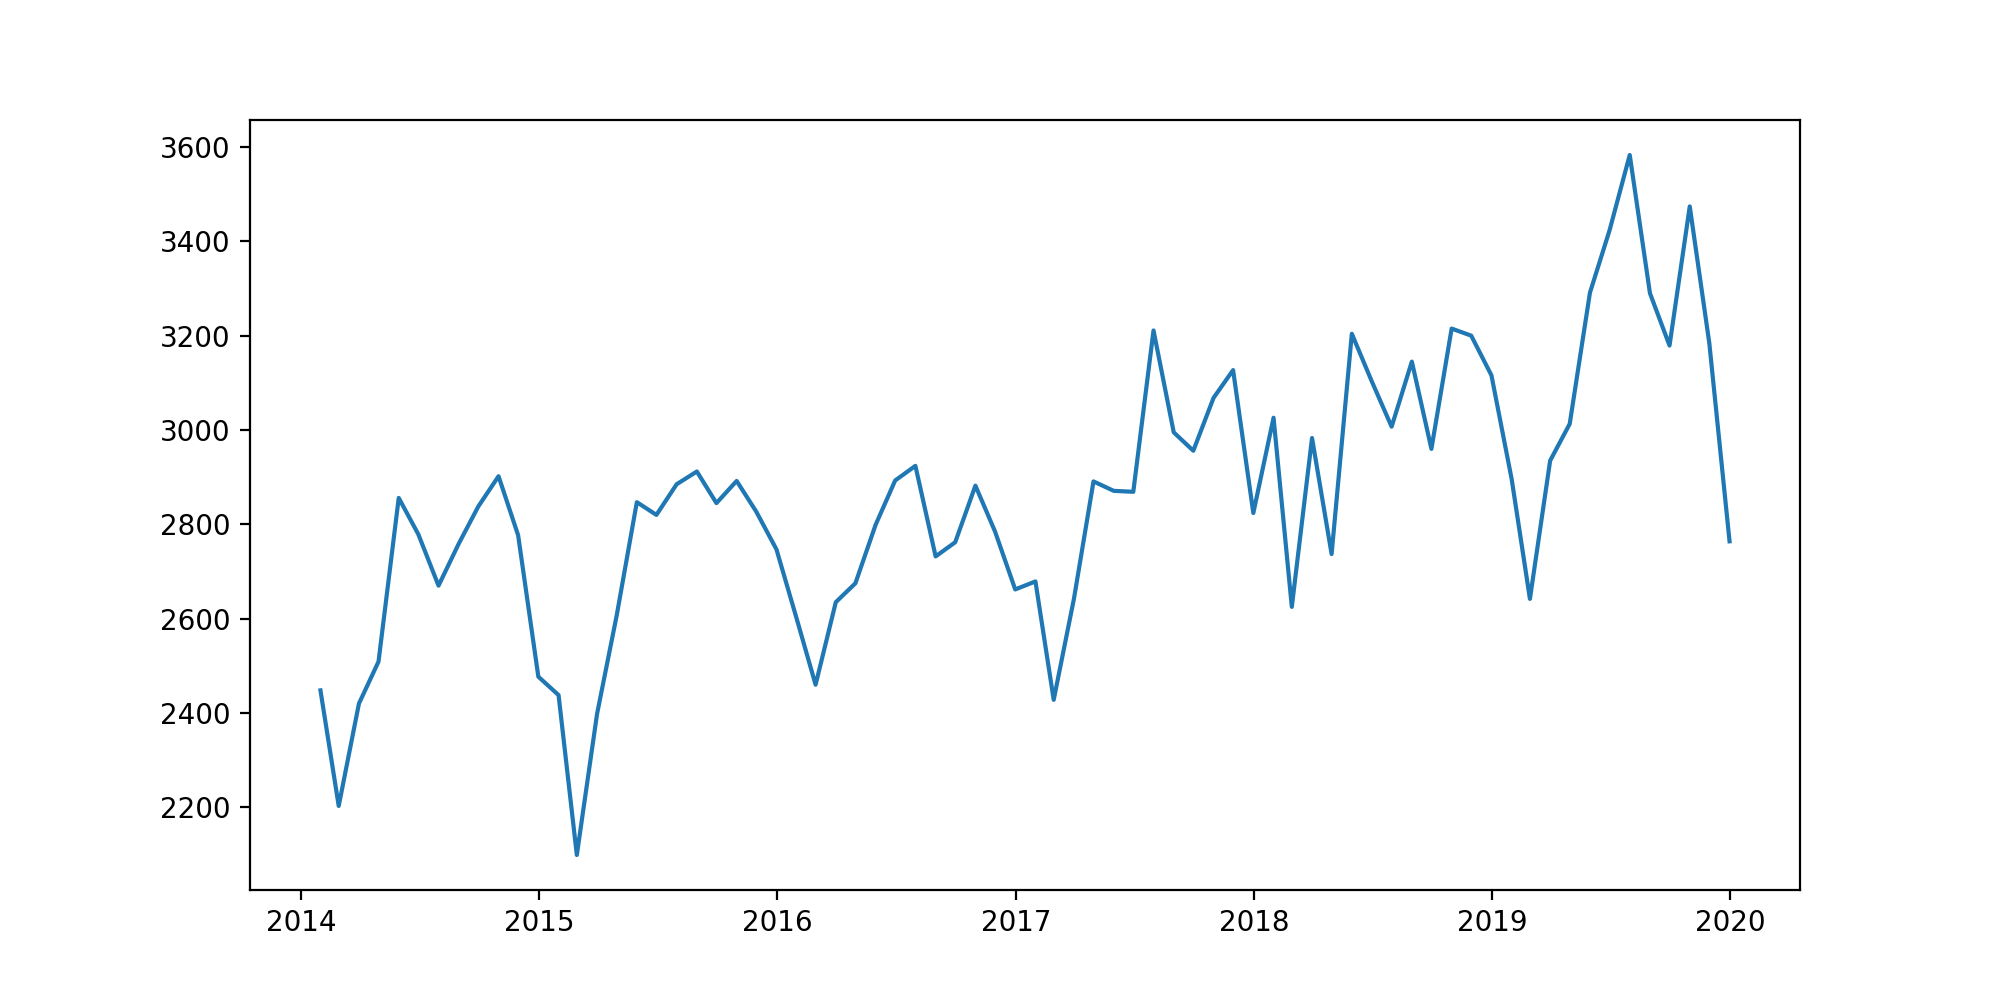

In [47]:
df_monthf = crime_byDay.groupby(pd.Grouper(key='occurrencedate', freq='1M')).sum()
df_monthfp = df_monthf['event_unique_id']
plt.figure(figsize=(10,5))
plt.plot(df_monthfp)


<IPython.core.display.Javascript object>


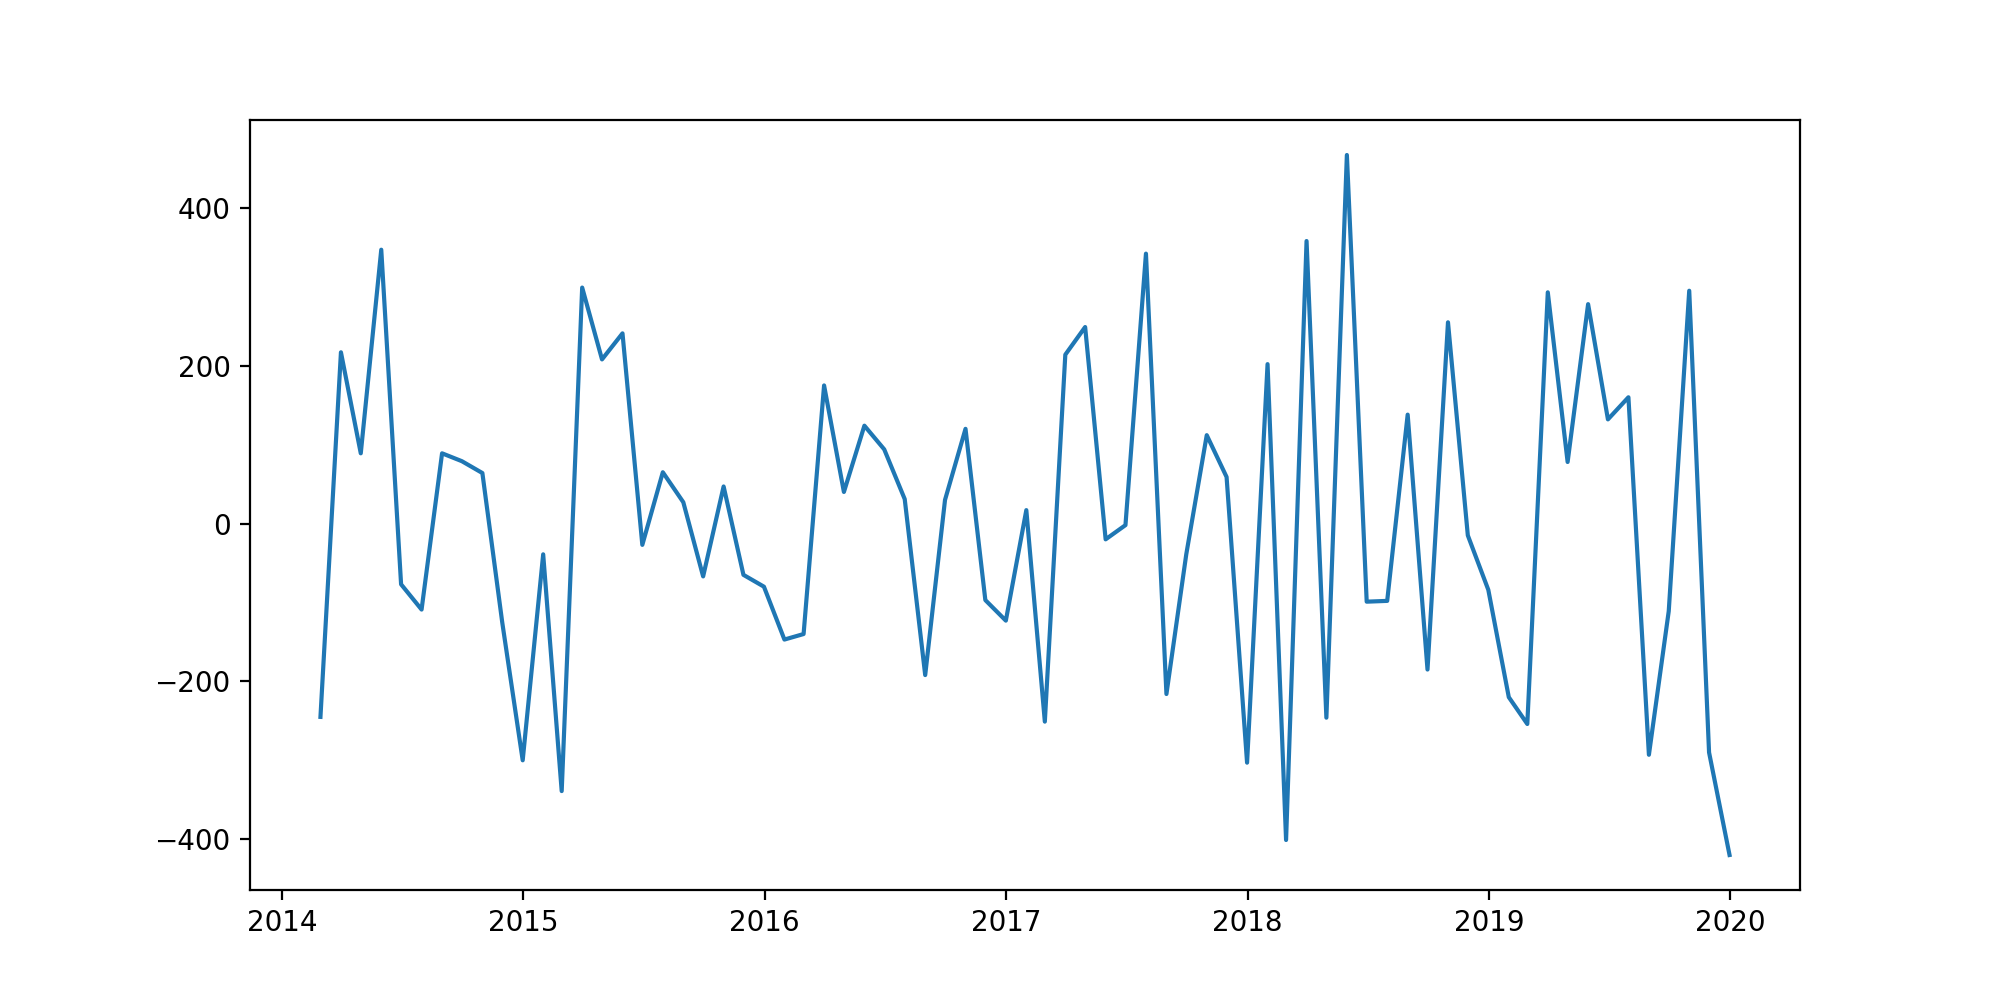

In [48]:
#make the series stationary by subtracting the previous value
plt.figure(figsize=(10,5))
plt.plot(df_monthfp.diff(periods=1))

<IPython.core.display.Javascript object>


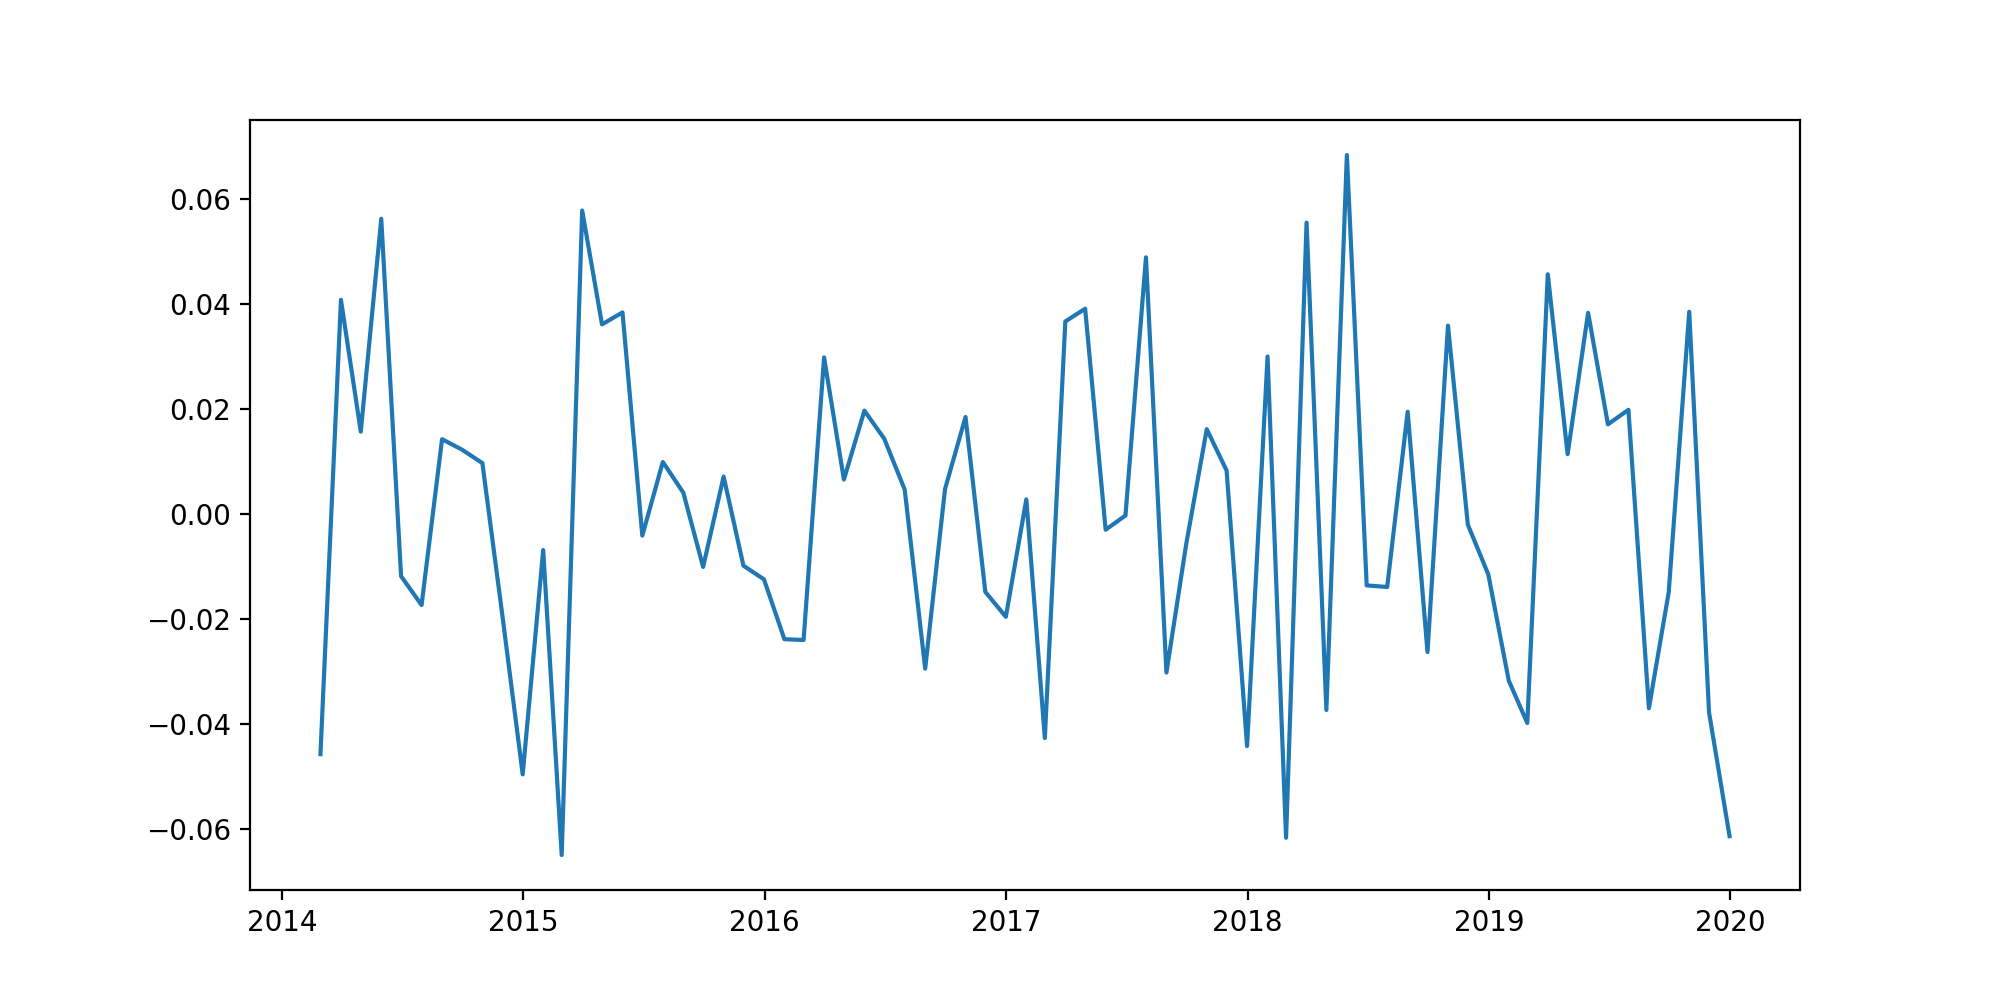

In [49]:
#make the series stationary by making the mean and variance of the series constant
plt.figure(figsize=(10,5))
plt.plot(np.log10(df_monthfp).diff(periods=1))

<IPython.core.display.Javascript object>


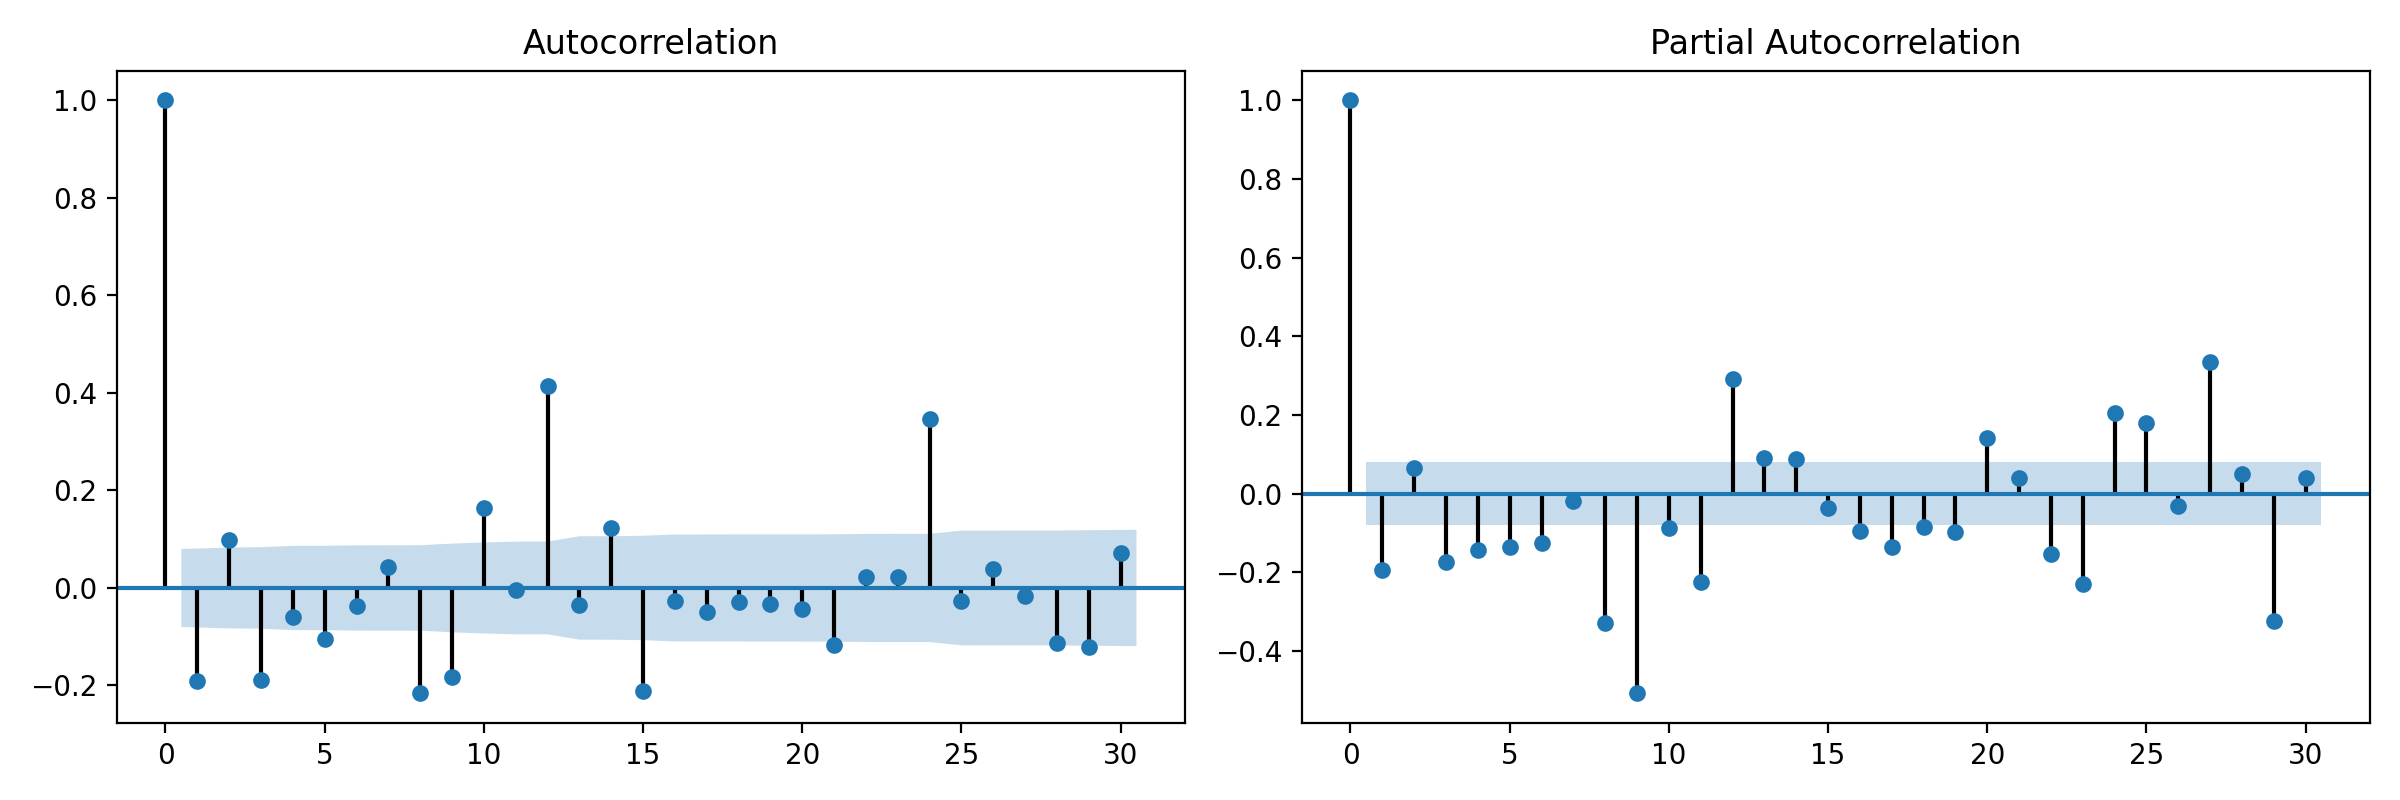

In [50]:
MCI_log = np.log10(df_monthfp)
MCI_log.dropna(inplace=True)

MCI_log_diff = MCI_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
MCI_log_diff.dropna(inplace=True)

fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(MCI_log_diff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(MCI_log_diff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

In [51]:
p = d = q = range(0, 3)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(MCI_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{} - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{} model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))


Unexpected error: <class 'numpy.linalg.LinAlgError'>
Unexpected error: <class 'numpy.linalg.LinAlgError'>
Unexpected error: <class 'numpy.linalg.LinAlgError'>
Unexpected error: <class 'numpy.linalg.LinAlgError'>
Unexpected error: <class 'numpy.linalg.LinAlgError'>


In [ ]:
#Step5 prediction

best_model = sm.tsa.statespace.SARIMAX(MCI_log, order=(1, 1, 1), seasonal_order=(2, 0, 1, 12), enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

idx = pd.date_range(df_monthf.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns

In [ ]:
# plot the forecast along with the confidence band
axis = df_monthf.plot(label='Observed', figsize=(9, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
#axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.75)
axis.set_xlabel('Years')
axis.set_ylabel('MCI')
plt.legend(loc='best')
plt.show()

In [ ]:
# validate Time series analysis result
best_results.plot_diagnostics(lags=30, figsize=(10,7))
plt.show()

In [ ]:
#Start with the simple LabelEncoder with the object type columns

In [ ]:
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder

In [53]:
#df_Master = pd.read_csv(r'C:\Users\sharm.LAPTOP-118C54MT\OneDrive - York University\Big Data Analytics course\Project\Merged dataframe\Masterdf_crime.csv',parse_dates=True)
#keep_cl
df_Master = pd.read_csv(os.path.join(sys.path[0], 'Masterdf_crime.csv'))

df_Master.columns

Index(['Unnamed: 0', 'event_unique_id', 'occurrencedate', 'reporteddate',
       'premisetype', 'offence', 'occurrenceyear', 'occurrencemonth',
       'occurrenceday', 'occurrencedayofyear', 'occurrencedayofweek',
       'occurrencehour', 'MCI', 'Hood_ID', 'Neighbourhood', 'Long', 'Lat',
       'Population', 'PopDen', 'Not_in_workforce', 'Resident_with_Credentials',
       'Resident_without_credentials', '15_to_24_WithCred',
       '25_to_65_WithCred', 'Average Household Income', 'TTL_RES_UNIT',
       'Soc_Units', 'RGI', 'CRCNumLocations'],
      dtype='object')

In [54]:
df_Master[['Long', 'Lat','Population', 'PopDen', 'Not_in_workforce', 'Resident_with_Credentials', 
          'Resident_without_credentials', '15_to_24_WithCred',
          '25_to_65_WithCred', 'Average Household Income', 'TTL_RES_UNIT',
          'Soc_Units', 'RGI', 'CRCNumLocations']].describe()

Long            Lat     Population         PopDen  \
count  205321.000000  205321.000000  205321.000000  205321.000000   
mean      -79.395038      43.707322   25286.285480    7069.787163   
std         0.104335       0.052708   12800.772886    5802.733736   
min       -79.639267      43.587093    6577.000000    1040.000000   
25%       -79.471481      43.661152   15935.000000    3565.000000   
50%       -79.393372      43.701092   22372.000000    5395.000000   
75%       -79.319893      43.752068   30526.000000    8943.000000   
max       -79.123100      43.850788   65913.000000   44321.000000   

       Not_in_workforce  Resident_with_Credentials  \
count     205321.000000              205321.000000   
mean        7256.050014               55984.744839   
std         3450.734931               40221.140527   
min         1760.000000                9595.000000   
25%         4605.000000               32530.000000   
50%         6765.000000               46190.000000   
75%         9300.000000               63610.000000   
max        18215.000000              220865.000000   

       Resident_without_credentials  15_to_24_WithCred  25_to_65_WithCred  \
count                 205321.000000      205321.000000      205321.000000   
mean                    4793.123110       24627.930728       31356.814111   
std                     3324.535265       16814.792576       23480.625436   
min                      595.000000        4185.000000        5410.000000   
25%                     2250.000000       14120.000000       18380.000000   
50%                     3855.000000       20920.000000       25270.000000   
75%                     6185.000000       27585.000000       37355.000000   
max                    14215.000000       91695.000000      129170.000000   

       Average Household Income   TTL_RES_UNIT      Soc_Units            RGI  \
count             205321.000000  205321.000000  205321.000000  205321.000000   
mean               49324.460235     103.049503    1018.527033     748.150106   
std                29365.187069     123.449214     858.690985     684.673173   
min                25989.000000       1.000000       4.000000       0.000000   
25%                32483.000000       5.000000     380.000000     290.000000   
50%                39740.000000      35.000000     754.000000     477.000000   
75%                54460.000000     179.000000    1360.000000    1077.000000   
max               308010.000000     719.000000    3399.000000    2926.000000   

       CRCNumLocations  
count    205321.000000  
mean          1.306705  
std           1.116654  
min           0.000000  
25%           0.000000  
50%           1.000000  
75%           2.000000  
max           5.000000

In [55]:
keep_cl = ['premisetype', 'occurrenceyear', 'occurrencemonth',
       'occurrenceday', 'occurrencedayofweek', 'occurrencehour', 'MCI',
       'PopDen', 'Not_in_workforce', 'Resident_with_Credentials',
       'Resident_without_credentials', 'Average Household Income', 'TTL_RES_UNIT',
       'Soc_Units', 'RGI', 'CRCNumLocations', 'Long', 'Lat']

In [56]:
#keep only the relevant features for the modelling
df_data = df_Master[keep_cl]
#Add a part of the Day feature to the data.
def PartofDay(a):
    if a in [23,0,1,2]:
        return 'Midnight'
    elif a in [3,4,5,6]:
        return 'Early Morning'
    elif a in [7,8,9,10]:
        return 'Morning'
    elif a in [11,12,13,14]:
        return 'Noon'
    elif a in [15,16,17,18]:
        return 'Evening'
    else:
        return 'Night'
df_data['PartofDay'] = df_data.occurrencehour.apply(PartofDay)
obj_cl = list(df_data.select_dtypes(['object']).columns)  #separate the object type columns for encoding 
num_cl = [col for col in keep_cl if col not in obj_cl] #store the remaining columns for later join 

<ipython-input-56-a41cb53bb2df>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['PartofDay'] = df_data.occurrencehour.apply(PartofDay)


In [57]:
#define a function for the label encoding

def EncodeLabel(col_name):
    '''this function returns a dataframe with encoded columns and a dictionry with the name of the encoders'''
    df_modeld = pd.DataFrame()
    Encoders = {}
    for col in col_name:
        Encoders['le' + col] = LabelEncoder()
        df_modeld[col] = Encoders['le' + col].fit_transform(df_data[col])
    return df_modeld, Encoders

In [58]:
df_modeld, Encoders = EncodeLabel(obj_cl)

In [59]:
df_modelH = df_modeld.join(df_data[num_cl]) #join the encoded columns with the numeric columns
df_modelH

premisetype  occurrencemonth  occurrencedayofweek  MCI  PartofDay  \
0                 1                7                    1    0          2   
1                 3               11                    2    2          1   
2                 1                7                    1    2          0   
3                 0                7                    1    2          1   
4                 1                8                    2    3          2   
...             ...              ...                  ...  ...        ...   
205316            4                2                    5    1          0   
205317            4                2                    5    1          1   
205318            4                2                    5    1          4   
205319            3                2                    5    1          2   
205320            2                2                    5    1          3   

        occurrenceyear  occurrenceday  occurrencehour   PopDen  \
0               2014.0           24.0               1   4948.0   
1               2014.0           27.0              16  14097.0   
2               2014.0           24.0               6   1117.0   
3               2014.0           24.0              15   6441.0   
4               2014.0            3.0               2   5442.0   
...                ...            ...             ...      ...   
205316          2019.0           24.0               4   1117.0   
205317          2019.0           24.0              16   2712.0   
205318          2019.0           24.0              19  44321.0   
205319          2019.0           24.0               0   5045.0   
205320          2019.0           24.0               8   4414.0   

        Not_in_workforce  Resident_with_Credentials  \
0                  13610                      74850   
1                   8950                      74030   
2                   9995                      58300   
3                   8885                      61775   
4                   3110                      34110   
...                  ...                        ...   
205316              9995                      58300   
205317             11725                     102580   
205318              5225                      44890   
205319              5240                      26470   
205320              7525                      33985   

        Resident_without_credentials  Average Household Income  TTL_RES_UNIT  \
0                              10835                     29573             1   
1                                985                     56526            35   
2                               8455                     31771           179   
3                               3330                     37379            10   
4                               2380                     49709             1   
...                              ...                       ...           ...   
205316                          8455                     31771           179   
205317                          6005                     52787           255   
205318                          3100                     32648           719   
205319                          6470                     32483           204   
205320                          8620                     34059             8   

        Soc_Units   RGI  CRCNumLocations       Long        Lat  
0            1014   630              3.0 -79.199081  43.800281  
1             754   313              0.0 -79.386383  43.662472  
2             950   411              0.0 -79.612595  43.720406  
3             111   109              1.0 -79.349121  43.782772  
4              84    48              0.0 -79.458778  43.664490  
...           ...   ...              ...        ...        ...  
205316        950   411              0.0 -79.611320  43.710690  
205317       1240  1178              2.0 -79.556908  43.610126  
205318       1704  1653              1.0 -79.375420  43.671280  
205319        849 

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

#scaled the numeric columns
scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(df_data[num_cl])

In [64]:
#join the scaled columns with the encoded columns
df_modeld = pd.concat([df_modeld, pd.DataFrame(scaled, columns=num_cl)], axis=1)
df_modeld

premisetype  occurrencemonth  occurrencedayofweek  MCI  PartofDay  \
0                 1                7                    1    0          2   
1                 3               11                    2    2          1   
2                 1                7                    1    2          0   
3                 0                7                    1    2          1   
4                 1                8                    2    3          2   
...             ...              ...                  ...  ...        ...   
205316            4                2                    5    1          0   
205317            4                2                    5    1          1   
205318            4                2                    5    1          4   
205319            3                2                    5    1          2   
205320            2                2                    5    1          3   

        occurrenceyear  occurrenceday  occurrencehour    PopDen  \
0            -1.522366       0.951774       -1.605902 -0.365654   
1            -1.522366       1.289523        0.474861  1.211021   
2            -1.522366       0.951774       -0.912314 -1.025862   
3            -1.522366       0.951774        0.336144 -0.108361   
4            -1.522366      -1.412469       -1.467184 -0.280521   
...                ...            ...             ...       ...   
205316        1.397361       0.951774       -1.189749 -1.025862   
205317        1.397361       0.951774        0.474861 -0.750990   
205318        1.397361       0.951774        0.891014  6.419613   
205319        1.397361       0.951774       -1.744619 -0.348938   
205320        1.397361       0.951774       -0.634879 -0.457680   

        Not_in_workforce  Resident_with_Credentials  \
0               1.841337                   0.469039   
1               0.490897                   0.448652   
2               0.793731                   0.057563   
3               0.472060                   0.143961   
4              -1.201501                  -0.543863   
...                  ...                        ...   
205316          0.793731                   0.057563   
205317          1.295075                   1.158480   
205318         -0.588586                  -0.275844   
205319         -0.584239                  -0.733814   
205320          0.077940                  -0.546971   

        Resident_without_credentials  Average Household Income  TTL_RES_UNIT  \
0                           1.817364                 -0.672616     -0.826654   
1                          -1.145463                  0.245241     -0.551236   
2                           1.101473                 -0.597766      0.615238   
3                          -0.440100                 -0.406791     -0.753749   
4                          -0.725855                  0.013095     -0.826654   
...                              ...                       ...           ...   
205316                      1.101473                 -0.597766      0.615238   
205317                      0.364526                  0.117913      1.230878   
205318                     -0.509282                 -0.567900      4.989517   
205319                      0.504396                 -0.573519      0.817751   
205320                      1.151104                 -0.519850     -0.769950   

        Soc_Units       RGI  CRCNumLocations      Long       Lat  
0       -0.005272 -0.172565         1.516404  1.878145  1.763667  
1       -0.308059 -0.635560        -1.170200  0.082953 -0.850919  
2       -0.079804 -0.492426        -1.170200 -2.085171  0.248227  
3       -1.056875 -0.933514        -0.274665  0.440090  1.431471  
4       -1.088319 -1.022607        -1.170200 -0.610920 -0.812634  
...           ...       ...              ...       ...       ...  
205316  -0.079804 -0.492426        -1.170200 -2.072959  0.063889  
205317   0.257920  0.627819         0.620870 -1.551440 -1.844036  
205318   0.798279  1.321583        -0.274665  0.18803

In [65]:
#tranin test split for the modelling
train_X, test_X, train_y, test_y = train_test_split(df_modeld.iloc[:,[i for i in range(18) if i != 3]],df_modeld['MCI'])

In [66]:
#feature importance of the different columns
lg_clf =LGBMClassifier(objective='multiclass', num_class=5).fit(train_X, train_y)

perm = PermutationImportance(lg_clf).fit(test_X, test_y)
eli5.show_weights(perm, feature_names=test_X.columns.tolist())

NameError: name 'LGBMClassifier' is not defined

In [67]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [ ]:
rand_clf = RandomForestClassifier(n_estimators=50, max_depth = 25, criterion = 'gini')
param_grid = {   'n_estimators': [20, 30, 50], 
                 'max_depth': [10, 15, 20, 25],
             }
grid_clf = GridSearchCV(rand_clf, param_grid, cv=10)
grid_clf.fit(train_X, train_y)
grid_clf.best_params_

In [ ]:
rand_bclf = RandomForestClassifier(n_estimators=50, max_depth = 20, criterion = 'gini', max_features=6)
rand_bclf.fit(train_X, train_y)

In [ ]:
y_pred = rand_bclf.predict(test_X)
y_training = rand_bclf.predict(train_X)
print("Testing Accuracy:", round(metrics.accuracy_score(test_y, y_pred) * 100, 2), "%")
print("Training Accuracy:", round(metrics.accuracy_score(train_y, y_training)* 100, 2), "%\n")
print( 'Classification report: \n', metrics.classification_report(test_y, y_pred), "\n")

In [ ]:
sns.barplot(x=[x for x in range(len(rand_bclf.feature_importances_))], y = rand_bclf.feature_importances_)

In [ ]:
#### modelling with one hot encodign

In [ ]:
df_modelH = df_data.drop(columns= ['Not_in_workforce', 'RGI', 'occurrencehour'])

In [ ]:
out = df_modelH['MCI']
df_modelH.drop(columns='MCI', inplace=True)
### change the columns to category type
df_modelH = df_modelH.astype({'premisetype':'category', 'occurrenceyear':'category', 'occurrencemonth':'category',
                             'occurrenceday':'category', 'occurrencedayofweek':'category', 'PartofDay':'category',
                             'CRCNumLocations':'category', 'Average Household Income':np.float64})
df_dumm_in = pd.get_dummies(df_modelH, columns=['premisetype', 'occurrenceyear', 'occurrencemonth',
                             'occurrenceday', 'occurrencedayofweek', 'PartofDay',
                             'CRCNumLocations'])

In [ ]:
#numeric columns for the one hot encoding
num_hcl = list(df_modelH.select_dtypes([np.float64,np.int64]).columns)
num_hcl

In [ ]:
#scale the data
scalerh = preprocessing.StandardScaler()
scaledh = scalerh.fit_transform(df_modelH[num_hcl])

In [ ]:
#get the dummy variables
df_dumm_in.drop(columns=num_hcl,inplace=True)
df_dumm_in

In [ ]:
df_dumm_in = df_dumm_in.join(pd.DataFrame(scaledh,columns=num_hcl))

In [ ]:
df_modelH.columns

In [ ]:
X_tranin, X_test , y_train, y_test = train_test_split(df_dumm_in,out)

In [ ]:
#random forest calssifire
rand_hclf = RandomForestClassifier(n_estimators=50, max_depth = 20, criterion = 'gini')
rand_hclf.fit(X_tranin, y_train)

In [ ]:
y_pred = rand_hclf.predict(X_test)
y_training = rand_hclf.predict(X_tranin)
print("Testing Accuracy:", round(metrics.accuracy_score(y_test, y_pred) * 100, 2), "%")
print("Training Accuracy:", round(metrics.accuracy_score(y_train, y_training)* 100, 2), "%\n")
print( 'Classification report: \n', metrics.classification_report(y_test, y_pred), "\n")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
leaf_size = [5,10,20,30,40,50]
n_neighbors = [5,10,20,30,40,50]
p=[1,2]
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
knn_para = KNeighborsClassifier()
best_knn_clf = GridSearchCV(knn_para, hyperparameters, cv=10)
best_knn_clf.fit(X_tranin, y_train)
best_knn_clf.best_params_

In [ ]:
#knn classifier
knn_clf = KNeighborsClassifier(n_neighbors=7, leaf_size = 5, p=1)
knn_clf.fit(X_tranin, y_train)

In [ ]:
knn_pred_test = knn_clf.predict(X_test)
knn_pred_train = knn_clf.predict(X_tranin)
print("Testing Accuracy:", round(metrics.accuracy_score(y_test, knn_pred_test) * 100, 2), "%")
print("Training Accuracy:", round(metrics.accuracy_score(y_train, knn_pred_train)* 100, 2), "%\n")
print( 'Classification report: \n', metrics.classification_report(y_test, knn_pred_test), "\n")

In [ ]:
knn_clf.score(X_test, y_test)

In [ ]:
#split the data into train test sets


In [ ]:
train_data = lgb.Dataset(X_tranin, label=y_train)

In [ ]:
params = {'boosting':'gbdt',
          'objective':'multiclass',
          'num_class':5,
          'max_delta_step':0.9,
          'min_data_in_leaf': 21,
          'learning_rate': 0.4,
          'max_bin': 465,
          'num_leaves': 41
         }

In [ ]:
bst = lgb.train(params, train_data, 100)

predictions = bst.predict(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)

In [ ]:
knn.fit(train_X,train_y)

In [ ]:
knn.score(test_X,test_y)

In [ ]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(C=100).fit(X_tranin, y_train)

In [ ]:
reg.score(X_test,y_test)

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC(kernel='linear', C=1).fit(train_X,train_y)

In [ ]:
svc.score(test_X, test_y)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
Lreg = LinearRegression().fit(X_tranin, y_train)

In [ ]:
Lreg.score(test_X, test_y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
Dclf = DecisionTreeClassifier().fit(X_tranin, y_train)

In [ ]:
Dclf.score(X_test,y_test)

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
nbclf = GaussianNB().fit(X_tranin, y_train)

In [ ]:
nbclf.score(X_test,y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rclf = RandomForestClassifier().fit(train_X,train_y)

In [ ]:
rclf.score(test_X, test_y)

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
nnclf = MLPClassifier(hidden_layer_sizes=3, solver='lbfgs').fit(X_tranin, y_train)

In [ ]:
nnclf.score(X_test,y_test)

In [ ]:
pred_rf = rclf.predict(pred_2019)

In [ ]:
ser_rf = pd.Series(pred_rf)

In [ ]:
ser_rf.map(label_dict)

In [ ]:
plt.scatter(x.index,x, label= 'Actual')
plt.scatter(y.index,y, label= 'Predicted')
plt.ylabel('crime count')
plt.title('Crime rate in 2019')
plt.legend()
plt.xticks([])

In [ ]:
x = (model_data[model_data.Year==2019]).target.value_counts()

In [ ]:
y = ser_rf.value_counts()

In [ ]:
x

In [ ]:
label_dict

In [ ]:
['Assault','Auto Theft','Break and Enter','Robbery','Theft Over']